# Initial Project Analysis Pipeline
## July 2023


Brief thoughts on pipeline here:
- Gather all data
- Identify first base receives that are outs and that are not outs, and those that are just bad throws, but not received (like that play 203)

    - Other considerations here:
        - I might need to filter out throws that start too close to first for my method?
        - vertical angle?
        - velos?

- Build a probability model for this
- Make some calibration plots


From there, the path might diverge a little bit
- run expectancy?
- Fields Above Average?



### TODO:
- throw in batter x,y, velo? 
- my model grabber needs to pick the throw before whatever event!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Rectangle
import os

# Matt written files
from src.utils import *
from src.plotting import Baseball_Field
from src.game import Game

In [2]:
# pandas options
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

## Prep Data

### Find throws to first that are just so bad the first baseman didn't catch it

- 203 in 1903_01_TeamNE_TeamA2 is the cannonical example

Distance between ball and player is large on average, should maybe clean up 12.199183415462679


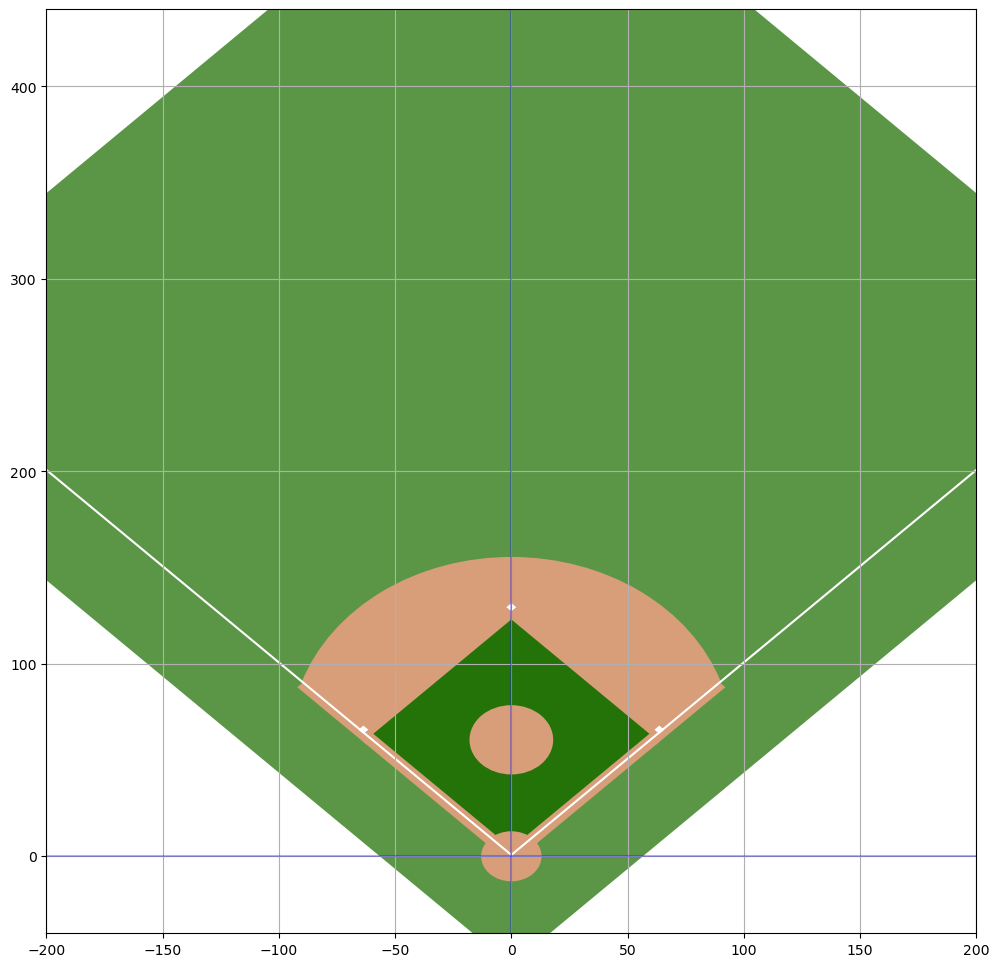

In [3]:
bf_1903_01 = Baseball_Field("1903_01_TeamNE_TeamA2")

In [5]:
game_events_1903_01 = bf_1903_01.game_obj.game_events_df.copy()
game_info_1903_01 = bf_1903_01.game_obj.game_info_df.copy()


game_events_1903_01.head(5)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,throw_bounced,batter_dist_to_first,thrower_x,thrower_y,ball_position_x,ball_position_y,ball_position_z,batter_x,batter_y,player_id
0,1903_01_TeamNE_TeamA2,1,1,1,19199,1,1,pitch,2.0,ball acquired,19661.0,NaN,NaN,NaN,NaN,NaN,NaN,0,89.076422,NaN,NaN,-2.387367,54.28680,6.37134,2.5305,-1.1700,2171
1,1903_01_TeamNE_TeamA2,1,1,1,19661,2,2,ball acquired,5.0,end of play,19661.0,1.0,pitch,19199.0,NaN,NaN,NaN,0,89.076422,NaN,NaN,-2.034057,-4.11549,3.61398,2.5305,-1.1700,2790
2,1903_01_TeamNE_TeamA2,1,1,1,19661,0,5,end of play,NaN,NaN,NaN,2.0,ball acquired,19661.0,NaN,NaN,NaN,0,89.076422,NaN,NaN,-2.034057,-4.11549,3.61398,2.5305,-1.1700,NaN
3,1903_01_TeamNE_TeamA2,2,1,2,29858,1,1,pitch,2.0,ball acquired,30320.0,NaN,NaN,NaN,NaN,NaN,NaN,0,89.114508,NaN,NaN,-2.288160,52.87770,6.40401,2.3136,-1.0173,2171
4,1903_01_TeamNE_TeamA2,2,1,2,30320,2,2,ball acquired,5.0,end of play,30320.0,1.0,pitch,29858.0,NaN,NaN,NaN,0,89.114508,NaN,NaN,-0.469218,-5.52300,0.34590,2.3136,-1.0173,2790


### Get all throws 

In [6]:
throws = game_events_1903_01.loc[game_events_1903_01["event"] == "throw (ball-in-play)", :]
throws.head(10)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,throw_bounced,batter_dist_to_first,thrower_x,thrower_y,ball_position_x,ball_position_y,ball_position_z,batter_x,batter_y,player_id
32,1903_01_TeamNE_TeamA2,10,2,10,179315,6,3,throw (ball-in-play),2.0,ball acquired,179942.0,2.0,ball acquired,178820.0,40.970997,2.162650,63.020815,0,76.027923,-56.0139,116.8362,-53.716200,114.3225,3.77541,7.2063,12.6933,1972
34,1903_01_TeamNE_TeamA2,10,2,10,180536,4,3,throw (ball-in-play),2.0,ball acquired,181361.0,2.0,ball acquired,179942.0,1.962933,2.041084,73.227697,0,47.089984,0.6681,129.3444,2.444979,126.2148,5.65056,29.2554,31.4652,2053
65,1903_01_TeamNE_TeamA2,18,4,18,461301,6,3,throw (ball-in-play),2.0,ball acquired,462225.0,2.0,ball acquired,460212.0,2.714353,3.179570,75.066867,0,45.904246,-1.5081,145.3005,-0.552351,140.5905,4.82034,29.9541,32.4549,6000
95,1903_01_TeamNE_TeamA2,25,6,25,616962,7,3,throw (ball-in-play),2.0,ball acquired,618777.0,2.0,ball acquired,615543.0,24.879819,17.746083,56.316458,0,15.056423,-141.4197,234.9465,-138.848100,234.1287,4.36419,56.8290,50.2116,3790
109,1903_01_TeamNE_TeamA2,28,7,28,714180,6,3,throw (ball-in-play),2.0,ball acquired,714840.0,2.0,ball acquired,713652.0,59.036393,1.662283,35.729095,0,53.972154,-28.8978,113.7537,-27.557250,109.6296,5.30967,26.5332,24.4464,6000
137,1903_01_TeamNE_TeamA2,36,8,36,1016790,9,3,throw (ball-in-play),16.0,ball bounce,1018407.0,2.0,ball acquired,1013886.0,19.781893,7.826560,59.497665,1,21.427403,36.3627,250.9065,34.939200,253.1502,6.06315,54.5067,83.0232,7148
149,1903_01_TeamNE_TeamA2,38,9,38,1094175,5,3,throw (ball-in-play),2.0,ball acquired,1095198.0,2.0,ball acquired,1092459.0,1.108531,1.218903,84.224138,0,60.608922,-59.9457,81.2073,-53.675100,77.8668,6.21342,20.2293,21.3432,9762
215,1903_01_TeamNE_TeamA2,58,13,58,1618117,6,3,throw (ball-in-play),2.0,ball acquired,1619239.0,2.0,ball acquired,1616896.0,2.358087,4.034777,72.686062,0,51.954068,-39.4440,125.9001,-35.535300,121.1655,5.69469,26.6307,27.1764,1972
255,1903_01_TeamNE_TeamA2,69,16,69,2010520,8,3,throw (ball-in-play),2.0,ball acquired,2012434.0,2.0,ball acquired,2009662.0,34.124119,18.471341,51.546902,0,5.490810,54.4110,239.0079,55.509000,236.3835,6.40218,61.1067,68.5113,4474
272,1903_01_TeamNE_TeamA2,73,17,73,2191492,5,3,throw (ball-in-play),2.0,ball acquired,2192317.0,2.0,ball acquired,2190634.0,48.628686,2.317024,73.219675,0,55.609675,-57.3255,61.6473,-56.929200,60.3264,6.11313,23.7630,24.8802,9762


#### Find all bounced throws 

In [9]:
throws = throws.loc[throws["throw_bounced"] == 1, :]
throws

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,throw_bounced,batter_dist_to_first,thrower_x,thrower_y,ball_position_x,ball_position_y,ball_position_z,batter_x,batter_y,player_id
137,1903_01_TeamNE_TeamA2,36,8,36,1016790,9,3,throw (ball-in-play),16.0,ball bounce,1018407.0,2.0,ball acquired,1013886.0,19.781893,7.826560,59.497665,1,21.427403,36.3627,250.9065,34.939200,253.15020,6.06315,54.5067,83.0232,7148
343,1903_01_TeamNE_TeamA2,91,23,91,2812124,9,3,throw (ball-in-play),16.0,ball bounce,2813873.0,2.0,ball acquired,2811134.0,1.068321,7.055677,82.496337,1,54.851135,152.4165,218.8929,163.285200,181.07190,6.57621,27.0003,22.8204,2973
419,1903_01_TeamNE_TeamA2,112,28,112,3492816,4,3,throw (ball-in-play),16.0,ball bounce,3493905.0,2.0,ball acquired,3492255.0,2.055354,2.196960,76.084736,1,85.298111,113.2272,115.5201,111.246300,112.33620,6.00135,4.8045,125.3988,6993
510,1903_01_TeamNE_TeamA2,129,34,129,4192812,7,3,throw (ball-in-play),16.0,ball bounce,4194660.0,2.0,ball acquired,4191591.0,18.541741,7.549302,73.381325,1,30.200478,-123.2232,247.8708,-118.559100,240.52260,7.43298,47.2086,38.3001,3790
778,1903_01_TeamNE_TeamA2,203,51,203,6591420,5,3,throw (ball-in-play),16.0,ball bounce,6592872.0,2.0,ball acquired,6590133.0,4.794717,4.903628,77.464142,1,63.594725,-65.7825,77.6067,-56.621100,74.62770,6.07932,18.2652,19.0812,2382
877,1903_01_TeamNE_TeamA2,229,60,230,7416850,2,3,throw (ball-in-play),16.0,ball bounce,7418071.0,2.0,ball acquired,7416289.0,45.814033,2.776990,73.589380,1,92.299609,-0.2760,-5.1276,0.940761,-4.29291,5.86710,-2.7900,-0.4410,7071
888,1903_01_TeamNE_TeamA2,230,60,231,7470706,4,3,throw (ball-in-play),16.0,ball bounce,7471993.0,2.0,ball acquired,7469914.0,2.201810,6.861494,57.222575,1,38.275326,-24.9810,151.2594,-27.408540,150.75720,6.46392,37.0431,36.1146,NaN
948,1903_01_TeamNE_TeamA2,244,64,245,8013457,8,3,throw (ball-in-play),16.0,ball bounce,8015206.0,2.0,ball acquired,8012236.0,36.066440,12.694060,53.556196,1,NaN,NaN,NaN,-14.103780,266.13270,7.09707,NaN,NaN,1751
970,1903_01_TeamNE_TeamA2,249,65,250,8144500,8,3,throw (ball-in-play),16.0,ball bounce,8146414.0,2.0,ball acquired,8143609.0,10.745200,6.754691,73.952777,1,45.615515,68.8116,379.6281,66.892500,385.06500,8.60043,42.5361,104.0799,1751
973,1903_01_TeamNE_TeamA2,249,65,250,8147437,6,3,throw (ball-in-play),16.0,ball bounce,8148691.0,2.0,ball acquired,8146777.0,23.866211,3.239482,84.456090,1,95.100930,26.9766,187.3440,25.662720,184.73130,5.98905,-9.1428,124.8516,1972


#### Find all of the throws to first that are outs

In [7]:
trusted_first_base_outs_plays = game_events_1903_01.loc[
    (game_events_1903_01["event"] == "ball acquired") &\
    (game_events_1903_01["player_position"] == 3) &\
    (game_events_1903_01["prev_event"] != "pickoff throw") &\
    (game_events_1903_01["play_per_game"].isin(game_info_1903_01.loc[(game_info_1903_01["this_play_outs"] >= 1)
                                                                     &\
                                                         (game_info_1903_01["trust_this_half"] == 1), "play_per_game"].values))
    , "play_per_game"
]

trusted_first_base_outs_plays

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,ball_position_x,ball_position_y,ball_position_z,batter_x,batter_y
35,1903_01_TeamNE_TeamA2,10,2,10,181361,3,2,ball acquired,5.0,end of play,182450.0,3.0,throw (ball-in-play),180536.0,NaN,NaN,NaN,23.812321,NaN,NaN,61.6866,65.9577,2.751036,45.9588,47.6892
181,1903_01_TeamNE_TeamA2,48,11,48,1376457,3,2,ball acquired,5.0,end of play,1377843.0,4.0,ball hit into play,1370550.0,NaN,NaN,NaN,5.415868,NaN,NaN,98.3451,97.2681,5.771700,61.8519,58.5273
216,1903_01_TeamNE_TeamA2,58,13,58,1619239,3,2,ball acquired,5.0,end of play,1620295.0,3.0,throw (ball-in-play),1618117.0,NaN,NaN,NaN,23.276346,NaN,NaN,59.6838,65.3253,2.773476,47.2962,47.0661
455,1903_01_TeamNE_TeamA2,119,30,119,3796416,3,2,ball acquired,5.0,end of play,3797835.0,3.0,throw (ball-in-play),3795327.0,NaN,NaN,NaN,27.688541,NaN,NaN,61.2504,67.7586,3.642990,43.5060,44.6319
484,1903_01_TeamNE_TeamA2,124,32,124,3914820,3,2,ball acquired,5.0,end of play,3916107.0,3.0,throw (ball-in-play),3913995.0,NaN,NaN,NaN,20.593925,NaN,NaN,63.9912,67.5339,4.300680,48.9084,49.2486
589,1903_01_TeamNE_TeamA2,149,39,149,4907329,3,2,ball acquired,5.0,end of play,4908055.0,3.0,throw (ball-in-play),4906405.0,NaN,NaN,NaN,2.266255,NaN,NaN,58.8330,66.2850,4.709610,61.6044,62.6427
718,1903_01_TeamNE_TeamA2,185,47,185,6121961,3,2,ball acquired,5.0,end of play,6122951.0,3.0,throw (ball-in-play),6121268.0,NaN,NaN,NaN,21.603012,NaN,NaN,59.3652,62.8815,6.934410,48.4122,48.3159
858,1903_01_TeamNE_TeamA2,223,58,224,7275642,3,2,ball acquired,5.0,end of play,7276500.0,3.0,throw (ball-in-play),7275147.0,NaN,NaN,NaN,20.634997,NaN,NaN,60.6081,67.4022,1.922883,48.4140,49.7118
907,1903_01_TeamNE_TeamA2,234,61,235,7713388,3,2,ball acquired,5.0,end of play,7714114.0,3.0,throw (ball-in-play),7712431.0,NaN,NaN,NaN,28.886532,NaN,NaN,64.6722,60.0243,5.423790,43.9923,42.4638
1017,1903_01_TeamNE_TeamA2,260,68,261,8669663,3,2,ball acquired,5.0,end of play,8670488.0,3.0,throw (ball-in-play),8668772.0,NaN,NaN,NaN,35.067428,NaN,NaN,61.6743,65.0712,2.361351,39.2451,38.4477


In [ ]:
game_events_1903_01.loc[(game_events_1903_01["event"] == "throw (ball-in-play)") &\
                        (game_events_1903_01["play_per_game"].isin(trusted_first_base_outs_plays.values)), :]

In [ ]:
bf_1903_01.clear_plot()

play_id = bf_1903_01.game_obj.get_pid_from_ppg(224)

#bf_1903_01.plot_all_components(play_id=play_id)
#bf_1903_01.fig
bf_1903_01.create_gif(play_id=play_id, tag="--1-3 out")

In [ ]:
trusted_first_base_not_outs_plays = game_events_1903_01.loc[
    (game_events_1903_01["event"] == "ball acquired") &\
    (game_events_1903_01["player_position"] == 3) &\
    (game_events_1903_01["prev_event"] != "pickoff throw") &\
    (game_events_1903_01["play_per_game"].isin(game_info_1903_01.loc[(game_info_1903_01["this_play_outs"] == 0) 
                                                                     #& (game_info_1903_01["trust_this_half"] == 1)
                                                                     ,
                                                                     "play_per_game"].values))
    , "play_per_game"
]

trusted_first_base_not_outs_plays

In [ ]:
throws.loc[throws["xy_throw_angle"] < 7]

In [ ]:
## HMM can I use the game info here?
# I think I can use just the trusted plays?
game_info_1903_01.loc[
    (game_info_1903_01["play_per_game"].isin(throws.loc[throws["xy_throw_angle"] < 7, "play_per_game"].values)) &
    (game_info_1903_01["this_play_outs"] == 0) &
    (game_info_1903_01["trust_this_play"] == 1)
    ,
    :
]


In [ ]:
game_info_1903_01.loc[
    (game_info_1903_01["play_per_game"].isin(throws.loc[(throws["xy_throw_angle"] < 7) &
                                                        (throws["player_position"].isin([1, 2, 4, 5, 6]))
                                                        , "play_per_game"].values)) &
    (game_info_1903_01["this_play_outs"] > 0) &
    (game_info_1903_01["trust_this_play"] == 1)
    ,
    :
]

In [ ]:
# NEED TO PICK THE CORRECT THROW -- do this by picking the min xy_angle?
# also need to make sure that they aren't back picks


In [ ]:
player_pos_1903_01 = bf_1903_01.game_obj.new_player_pos.copy()
player_pos_1903_01.head(3)

In [ ]:
ball_pos_1903_01 = bf_1903_01.game_obj.new_ball_pos.copy()
ball_pos_1903_01.head(3)

In [ ]:
temp_throw = throws[throws["play_id"] == 203]
temp_throw

In [ ]:
# get batter dist to first at time of throw!
ball_pos_df = ball_pos_1903_01

timestamp = temp_throw["timestamp"].values[0]

# find the x, y pos of the batter at the time of throw
# player pos and velo
batter_data = player_pos_1903_01.loc[(player_pos_1903_01["timestamp"] == timestamp) &\
                                     (player_pos_1903_01["player_position"] == 10)
                                     , ["play_id", "field_x", "field_y", "velo_x", "velo_y"]]


target_point = np.array([63.63961031, 63.63961031])

batter_pos_at_throw = batter_data[["field_x", "field_y"]].values[0]

batter_vect_to_first = (target_point - batter_pos_at_throw)

# find the distance of the batter to first
batter_dist_to_first = np.sqrt(batter_vect_to_first.dot(batter_vect_to_first))

# batter_dist_to_first

"""
# get batter velo over the whole time before the throw!
# velo is harder because I don't necessarily know when the batter starts to go
# its not at the pitch, it could be when the ball is hit, but the ball isn't
# always hit! Maybe the first event after the pitch?

batter_dist_from_home = np.sqrt(batter_pos_at_throw.dot(batter_pos_at_throw))

game_events_1903_01.loc[
    game_events_1903_01["play_id"] == temp_throw["play_id"].values[0]
].groupby("play_id").first()["timestamp"].values[0]
"""

In [ ]:
game_events_1903_01.loc[
    game_events_1903_01["play_id"] == temp_throw["play_id"].values[0]
].groupby("play_id").first()["timestamp"].values[0]

In [ ]:
temp_throw.timestamp

In [ ]:
# turn the 

In [ ]:
# player pos and velo
player_pos_1903_01.loc[(player_pos_1903_01["timestamp"] == timestamp) &\
                       (player_pos_1903_01["player_position"] == temp_throw["player_position"].values[0])
                       , ["play_id", "field_x", "field_y", "velo_x", "velo_y"]]

In [ ]:
# calculate the angle of elevation
# I think this is literally just PI - arccos(z_comp_of_velo) 

ball_pos_df = ball_pos_1903_01

timestamp = temp_throw["timestamp"].values[0]

buffer_ms = -10
snapshot_time = 250

# find when the ball is in the air with a buffer or not
ball_in_air_df = ball_pos_df.loc[(ball_pos_df["timestamp"] >= (timestamp - buffer_ms)) &\
                                   (ball_pos_df["timestamp"] <= (timestamp + snapshot_time)),
                                   # (ball_pos_1903_01["timestamp"] <= temp_throws["next_event_ts"].values[0] + buffer_ms), # this is for the whole throw
                                   :
                                  ] 

In [ ]:
throw_velo_vect = ball_in_air_df[["ball_position_x", "ball_position_y", "ball_position_z"]].iloc[-1].values \
    - ball_in_air_df[["ball_position_x", "ball_position_y", "ball_position_z"]].iloc[0].values
#throw_velo_vect

ball_flight_time_sec = (ball_in_air_df["timestamp"].iloc[-1] - ball_in_air_df["timestamp"].iloc[0])/1000

unit_z_vect = np.array([0, 0, 1])


elevation_angle_rad = (np.pi/2 - np.arccos(throw_velo_vect.dot(unit_z_vect) / np.sqrt(throw_velo_vect.dot(throw_velo_vect))))
elevation_angle_deg = elevation_angle_rad * 180 / np.pi
elevation_angle_deg

# this is feet per (ball_flight_time) * 1.467 [fps to mph]
np.sqrt(throw_velo_vect.dot(throw_velo_vect)) / ball_flight_time_sec


In [ ]:
def compute_throw_angle(a, target_point = np.array([63.63961031, 63.63961031])):
    """
    target_point defaults to first base
    
    """
    
    # TODO: do I NEED THE angle of inclination even here?
    # I think not for now!
        
    # make a vector from the first point to the target point
    xy_vect_to_target = target_point - a[["ball_position_x", "ball_position_y"]].iloc[0].values

    # scale it to be a unit vector
    unit_xy_vect_to_target = xy_vect_to_target / np.sqrt(xy_vect_to_target.dot(xy_vect_to_target))
    
    # Maybe the whole window so we don't get noise?
    throw_velo_xy_vect = a[["ball_position_x", "ball_position_y"]].iloc[-1].values \
        - a[["ball_position_x", "ball_position_y"]].iloc[0].values
    
    # the other one is a unit vect, so we don't need to divide here
    xy_angle_to_first_rad = np.arccos(throw_velo_xy_vect.dot(unit_xy_vect_to_target) / np.sqrt(throw_velo_xy_vect.dot(throw_velo_xy_vect)))
    
    xy_angle_to_first_deg = xy_angle_to_first_rad * 180 / np.pi

    # hmm there are some times where you might want to miss the bag -- e.g. throws from catcher! 

    return xy_angle_to_first_deg
    
    

In [ ]:
def fill_throw_angle(timestamp, ball_pos_df, target_point = np.array([63.63961031, 63.63961031])): 
    """
    
    """
    
    ball_pos_df = ball_pos_df.copy()
    
    buffer_ms = -10
    snapshot_time = 250

    # find when the ball is in the air with a buffer or not
    ball_in_air_df = ball_pos_df.loc[(ball_pos_df["timestamp"] >= (timestamp - buffer_ms)) &\
                                       (ball_pos_df["timestamp"] <= (timestamp + snapshot_time)),
                                       # (ball_pos_1903_01["timestamp"] <= temp_throws["next_event_ts"].values[0] + buffer_ms), # this is for the whole throw
                                       :
                                      ] 
    
    # print(ball_in_air_df["play_id"].describe())
    angle = compute_throw_angle(ball_in_air_df, target_point)
    
    return angle
    
    
    

In [ ]:
# Find plays where there is a throw and no ball acquired before the end of the play
# these are throwing errors, but we can't guarantee that they are thrown to first yet

game_events_1903_01.loc[(game_events_1903_01["event"].isin(["ball bounce", "throw (ball-in-play)"])) &\
                        (game_events_1903_01["next_event"] == "end of play")
                        # I have the angle already!
                        # need another condition that says this is going to first?
                        
                        , :]

In [ ]:
throws["xy_throw_angle"] = np.nan
throws["xy_throw_angle"] = throws.apply(lambda row: fill_throw_angle(row["timestamp"], ball_pos_1903_01), axis = 1)

In [ ]:
throws["xy_throw_angle"].loc[(throws["player_position"].isin([1, 2, 4, 5, 6]))].plot(kind="hist")

In [ ]:
# because this is like the cosine similarity to each other, we don't have a sense for which side of the bag the throw went to
# want infielder throws only
# note that higher angles throws are either throws behind a runner (usually in the [5, 10] range)
# or they are bad throws?

throws.loc[(throws["xy_throw_angle"] > 100) & (throws["player_position"].isin([1, 2, 4, 5, 6]) ), :]

In [ ]:
# look at all of these with the outs

In [ ]:
game_info_1903_01 = bf_1903_01.game_obj.game_info_df.copy()

In [ ]:
game_info_1903_01.loc[game_info_1903_01["play_per_game"] == 124]

game_info_1903_01.loc[(game_info_1903_01["inning"] == 4) & (game_info_1903_01["top_bottom_inning"] == "Top")]

In [ ]:
bf_1903_01.clear_plot()

play_id = 25 # throws.loc[throws["xy_throw_angle"] < 5, :].play_id.iloc[1] # bf_1903_01.game_obj.get_pid_from_ppg(75)

bf_1903_01.plot_all_components(play_id=play_id)
bf_1903_01.fig

# bf_1903_01.create_gif(play_id=play_id, tag="--4-6-3 dp")

In [ ]:
throws[["xy_throw_angle", "elevation_throw_angle", "throw_velo"]].describe()

In [ ]:
throws[["xy_throw_angle", "elevation_throw_angle", "throw_velo"]].plot(kind="hist", alpha=0.5)

### the method I have below pulls the end play, but I want the last throw before that!

In [71]:
bf = Baseball_Field("1902_25_TeamMH_TeamA3")
g = bf.game_obj
g_game_info = g.game_info_df.copy()
g_game_events = g.game_events_df.copy()

In [84]:
trusted_successful_first_base_outs_plays = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] >= 1) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , "play_per_game"
    ]

In [85]:
trusted_successful_first_base_outs_plays

33       12
263      80
295      88
335      99
610     170
659     181
910     249
998     275
1188    326
Name: play_per_game, dtype: int64

In [86]:
g_game_events.loc[
    (g_game_events["play_per_game"].isin(trusted_successful_first_base_outs_plays.values)) &
    (g_game_events["event"] == "throw (ball-in-play)")
].groupby("play_per_game").last()

,game_str,play_id,at_bat,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y
play_per_game,,,,,,,,,,,,,,,,,,,
80,1902_25_TeamMH_TeamA3,79,20.0,2444212,5,3,throw (ball-in-play),2.0,ball acquired,2444962.0,2.0,ball acquired,2443512.0,2.491820,-0.084918,77.544512,32.975824,-14.9730,27.7920
88,1902_25_TeamMH_TeamA3,87,21.0,2606462,5,3,throw (ball-in-play),2.0,ball acquired,2607462.0,2.0,ball acquired,2605012.0,2.454529,2.638689,77.284232,46.759101,-46.3131,92.2386
170,1902_25_TeamMH_TeamA3,169,42.0,5465212,5,3,throw (ball-in-play),2.0,ball acquired,5466312.0,2.0,ball acquired,5463612.0,4.565915,3.208294,75.142339,47.364506,-54.8901,88.4364
249,1902_25_TeamMH_TeamA3,248,61.0,8107997,1,3,throw (ball-in-play),2.0,ball acquired,8108997.0,2.0,ball acquired,8106447.0,4.205651,21.373355,23.795683,55.840902,27.2151,53.7417
275,1902_25_TeamMH_TeamA3,274,66.0,8908047,2,3,throw (ball-in-play),2.0,ball acquired,8909097.0,2.0,ball acquired,8907147.0,0.359665,9.576964,48.236728,43.370616,17.8644,6.3603
326,1902_25_TeamMH_TeamA3,325,77.0,10595297,4,3,throw (ball-in-play),2.0,ball acquired,10596147.0,2.0,ball acquired,10594747.0,0.897302,5.358753,69.263296,25.381376,-0.6981,131.6634


In [89]:
bf.clear_plot()

play_id = 169 #bf.game_obj.get_pid_from_ppg(224)

#bf.plot_all_components(play_id=play_id)
#bf.fig
# bf.create_gif(play_id=play_id, tag="--5-3 out")

MovieWriter ffmpeg unavailable; using Pillow instead.


## Collect the plays into a csv, will use this to compute features later

In [10]:
all_games = get_all_game_strs()

Gathered a list of 97 games


### Use full sequences as outs ground truth

In [11]:

total_trusted_outs = 0

# this should be a slight overcount tbh, because I will need to filter
# see issue #34, #6, etc
total_trusted_successful_first_base_outs = 0 
total_trusted_unsuccessful_first_base_outs = 0
total_throws_out_of_play = 0
total_trusted_double_plays = 0

model_dataset = pd.DataFrame()

cols_to_save = ["game_str", "play_id", "player_id", #"play_per_game",
                "player_position",
                "xy_throw_angle", "elevation_throw_angle",
                "throw_bounced",
                "throw_velo", "batter_dist_to_first",
                "thrower_x","thrower_y",
                "batter_x","batter_y",
                "ball_position_x", "ball_position_y", "ball_position_z",
                "type"]


for which_game in all_games:
    if which_game in ["1902_19_TeamME_TeamA2", "1902_13_TeamMD_TeamA2", "1902_03_TeamMG_TeamA3", "1901_13_TeamLL_TeamB",
                     "1902_18_TeamMB_TeamA1", "1900_02_TeamKJ_TeamB", "1901_06_TeamLI_TeamA3", "1902_27_TeamMH_TeamA3",
                     "1902_13_TeamMK_TeamB", "1903_27_TeamNH_TeamA3", "1902_07_TeamMJ_TeamB", "1902_20_TeamME_TeamA2",
                     "1902_30_TeamMF_TeamA2", "1901_05_TeamLI_TeamA3", "1901_17_TeamLH_TeamA3", "1902_21_TeamME_TeamA2",
                     ""]:
        continue
    
    print("Which game: {}".format(which_game))

    bf = Baseball_Field(which_game)
    g = bf.game_obj
    g_game_info = g.game_info_df.copy()
    g_game_events = g.game_events_df.copy()
    
    trusted_outs = g_game_info.loc[(g_game_info["this_play_outs"] > 0) & (g_game_info["trust_this_half"] == 1), :]
    
    trusted_outs["type"] = "trusted_out"
    model_dataset = pd.concat([model_dataset, trusted_outs[["game_str", "play_per_game", "type"]]])
    trusted_outs = trusted_outs.shape[0]
    
    # NOTE: WILL DEAL WITH FILTERING 
    
    # find the plays that are outs, that we trust, and end with the first baseman
    trusted_successful_first_base_outs_receives = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] >= 1) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , :
    ]
    
    # get the last throw! (I am assuming this is a throw to first because it end with first!)
    trusted_successful_first_base_outs_throws = g_game_events.loc[
        (g_game_events["play_per_game"].isin(trusted_successful_first_base_outs_receives["play_per_game"].values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    trusted_successful_first_base_outs_throws["type"] = "trusted_first_base_out_throws"
    model_dataset = pd.concat([model_dataset, trusted_successful_first_base_outs_throws[cols_to_save]])
    trusted_successful_first_base_outs_throws = trusted_successful_first_base_outs_throws.shape[0]
    
    
    trusted_successful_first_base_outs_receives["type"] = "trusted_first_base_out_receives"
    model_dataset = pd.concat([model_dataset, trusted_successful_first_base_outs_receives[cols_to_save]])
    
    trusted_unsuccessful_first_base_outs_receives = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] == 0) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , :
    ]
    
    trusted_unsuccessful_first_base_outs_receives["type"] = "trusted_first_base_not_out_receives"
    model_dataset = pd.concat([model_dataset, trusted_unsuccessful_first_base_outs_receives[cols_to_save]])
    
    trusted_unsuccessful_first_base_outs_throws = g_game_events.loc[
        (g_game_events["play_per_game"].isin(trusted_unsuccessful_first_base_outs_receives["play_per_game"].values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    trusted_unsuccessful_first_base_outs_throws["type"] = "trusted_first_base_not_out_throws"
    model_dataset = pd.concat([model_dataset, trusted_unsuccessful_first_base_outs_throws[cols_to_save]])
    trusted_unsuccessful_first_base_outs_throws = trusted_unsuccessful_first_base_outs_throws.shape[0]

    
    trusted_double_plays = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] == 2) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , "play_per_game"
    ]
    
    # I think I want all throws! there should be some overlap here! 
    trusted_double_plays_throws = g_game_events.loc[
        (g_game_events["play_per_game"].isin(trusted_double_plays.values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ]#.groupby("play_per_game").last()
    
    trusted_double_plays_throws["type"] = "trusted_double_play"
    model_dataset = pd.concat([model_dataset, trusted_double_plays_throws[cols_to_save]])
    trusted_double_plays_throws = trusted_double_plays_throws.shape[0]

    
    # TODO: Add overthrows here!
    throws_out_of_play = g_game_events.loc[
        (g_game_events["event"].isin(["ball bounce", "throw (ball-in-play)"])) &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["xy_throw_angle"] <= 10)
        , "play_per_game"
    ]
    
    throws_out_of_play = g_game_events.loc[
        (g_game_events["play_per_game"].isin(throws_out_of_play.values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    throws_out_of_play["type"] = "throws_to_end_play"
    model_dataset = pd.concat([model_dataset, throws_out_of_play[cols_to_save]])
    throws_out_of_play = throws_out_of_play.shape[0]    
    
    print("{} trusted outs in this game \n{} trusted first base outs\t{} trusted_first_base_not_outs --- \t trusted double plays {} \t throws to end play {}\n".format(
        trusted_outs,
        trusted_successful_first_base_outs_throws,
        trusted_unsuccessful_first_base_outs_throws,
        trusted_double_plays_throws,
        throws_out_of_play
    ))
    
    
    total_trusted_outs += trusted_outs
    total_trusted_successful_first_base_outs += trusted_successful_first_base_outs_throws
    total_trusted_unsuccessful_first_base_outs += trusted_unsuccessful_first_base_outs_throws
    total_trusted_double_plays += trusted_double_plays_throws
    total_throws_out_of_play += throws_out_of_play
    
    plt.close()

    
print("---------------")    

print("{} trusted outs in this game \n{} trusted first base outs\t{} trusted_first_base_not_outs --- \t trusted double plays {} \t throws to end play {}\n".format(
    total_trusted_outs,
    total_trusted_successful_first_base_outs,
    total_trusted_unsuccessful_first_base_outs,
    total_trusted_double_plays,
    total_throws_out_of_play
    
))


Which game: 1903_01_TeamNE_TeamA2
Distance between ball and player is large on average, should maybe clean up 12.199183415462679



KeyboardInterrupt



### Use outs at first as outs ground truth

In [12]:

total_trusted_outs = 0

# this should be a slight overcount tbh, because I will need to filter
# see issue #34, #6, etc
total_trusted_successful_first_base_outs = 0 
total_trusted_unsuccessful_first_base_outs = 0
total_throws_out_of_play = 0
total_trusted_double_plays = 0

model_dataset = pd.DataFrame()

cols_to_save = ["game_str", "play_id", "player_id", #"play_per_game",
                "player_position",
                "xy_throw_angle", "elevation_throw_angle",
                "throw_bounced",
                "throw_velo", "batter_dist_to_first",
                "thrower_x","thrower_y",
                "batter_x","batter_y",
                "ball_position_x", "ball_position_y", "ball_position_z",
                "type"]


for which_game in all_games:
    """
    if which_game in ["1902_19_TeamME_TeamA2", "1902_13_TeamMD_TeamA2", "1902_03_TeamMG_TeamA3", "1901_13_TeamLL_TeamB",
                     "1902_18_TeamMB_TeamA1", "1900_02_TeamKJ_TeamB", "1901_06_TeamLI_TeamA3", "1902_27_TeamMH_TeamA3",
                     "1902_13_TeamMK_TeamB", "1903_27_TeamNH_TeamA3", "1902_07_TeamMJ_TeamB", "1902_20_TeamME_TeamA2",
                     "1902_30_TeamMF_TeamA2", "1901_05_TeamLI_TeamA3", "1901_17_TeamLH_TeamA3", "1902_21_TeamME_TeamA2",
                     ""]:
        continue
    """
    
    print("Which game: {}".format(which_game))

    bf = Baseball_Field(which_game, which_outs=["at_first"])
    g = bf.game_obj
    g_game_info = g.game_info_df.copy()
    g_game_events = g.game_events_df.copy()
    
    """
    trusted_outs = g_game_info.loc[(g_game_info["this_play_outs"] > 0) & (g_game_info["trust_this_half"] == 1), :]
    
    trusted_outs["type"] = "trusted_out"
    model_dataset = pd.concat([model_dataset, trusted_outs[["game_str", "play_per_game", "type"]]])
    trusted_outs = trusted_outs.shape[0]
    
    # NOTE: WILL DEAL WITH FILTERING 
    
    """
    
    # find the plays that are outs, that we trust, and end with the first baseman
    trusted_successful_first_base_outs_receives = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["is_out_at_first"] == 1), "play_per_game"].values))
        , :
    ]
    
    # get the last throw! (I am assuming this is a throw to first because it end with first!)
    trusted_successful_first_base_outs_throws = g_game_events.loc[
        (g_game_events["play_per_game"].isin(trusted_successful_first_base_outs_receives["play_per_game"].values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    trusted_successful_first_base_outs_throws["type"] = "trusted_first_base_out_throws"
    model_dataset = pd.concat([model_dataset, trusted_successful_first_base_outs_throws[cols_to_save]])
    trusted_successful_first_base_outs_throws = trusted_successful_first_base_outs_throws.shape[0]
    
    
    trusted_successful_first_base_outs_receives["type"] = "trusted_first_base_out_receives"
    model_dataset = pd.concat([model_dataset, trusted_successful_first_base_outs_receives[cols_to_save]])
    
    trusted_unsuccessful_first_base_outs_receives = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["is_out_at_first"] == -1), "play_per_game"].values))
        , :
    ]
    
    trusted_unsuccessful_first_base_outs_receives["type"] = "trusted_first_base_not_out_receives"
    model_dataset = pd.concat([model_dataset, trusted_unsuccessful_first_base_outs_receives[cols_to_save]])
    
    trusted_unsuccessful_first_base_outs_throws = g_game_events.loc[
        (g_game_events["play_per_game"].isin(trusted_unsuccessful_first_base_outs_receives["play_per_game"].values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    trusted_unsuccessful_first_base_outs_throws["type"] = "trusted_first_base_not_out_throws"
    model_dataset = pd.concat([model_dataset, trusted_unsuccessful_first_base_outs_throws[cols_to_save]])
    trusted_unsuccessful_first_base_outs_throws = trusted_unsuccessful_first_base_outs_throws.shape[0]

    
    throws_out_of_play = g_game_events.loc[
        (g_game_events["event"].isin(["ball bounce", "throw (ball-in-play)"])) &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["xy_throw_angle"] <= 10)
        , "play_per_game"
    ]
    
    throws_out_of_play = g_game_events.loc[
        (g_game_events["play_per_game"].isin(throws_out_of_play.values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    throws_out_of_play["type"] = "throws_to_end_play"
    model_dataset = pd.concat([model_dataset, throws_out_of_play[cols_to_save]])
    throws_out_of_play = throws_out_of_play.shape[0]    
    
    print("{} trusted first base outs\t{} trusted_first_base_not_outs --- \t throws to end play {}\n".format(
        #trusted_outs,
        trusted_successful_first_base_outs_throws,
        trusted_unsuccessful_first_base_outs_throws,
        throws_out_of_play
    ))
    
    
    total_trusted_successful_first_base_outs += trusted_successful_first_base_outs_throws
    total_trusted_unsuccessful_first_base_outs += trusted_unsuccessful_first_base_outs_throws
    total_throws_out_of_play += throws_out_of_play
    
    plt.close()

    
print("---------------")    

print("{} trusted first base outs\t{} trusted_first_base_not_outs --- \t throws to end play {}\n".format(
    total_trusted_successful_first_base_outs,
    total_trusted_unsuccessful_first_base_outs,
    total_throws_out_of_play
    
))


Which game: 1903_01_TeamNE_TeamA2
Distance between ball and player is large on average, should maybe clean up 12.199183415462679
12 trusted first base outs	1 trusted_first_base_not_outs --- 	 throws to end play 0

Which game: 1903_16_TeamNI_TeamA3
8 trusted first base outs	1 trusted_first_base_not_outs --- 	 throws to end play 0

Which game: 1902_02_TeamMG_TeamA3
11 trusted first base outs	1 trusted_first_base_not_outs --- 	 throws to end play 0

Which game: 1903_08_TeamNJ_TeamB
17 trusted first base outs	3 trusted_first_base_not_outs --- 	 throws to end play 0

Which game: 1900_08_TeamKL_TeamB
0 trusted first base outs	0 trusted_first_base_not_outs --- 	 throws to end play 0

Which game: 1903_23_TeamNA_TeamA1
9 trusted first base outs	2 trusted_first_base_not_outs --- 	 throws to end play 0

Which game: 1902_19_TeamME_TeamA2
2 trusted first base outs	2 trusted_first_base_not_outs --- 	 throws to end play 0

Which game: 1901_08_TeamLK_TeamB
5 trusted first base outs	1 trusted_first_bas

In [13]:
# Write the model_dataset 
model_dataset.to_csv("new_model_dataset.csv")

## See some of the overthrows and make heatmaps

In [14]:
model_dataset = pd.read_csv("new_model_dataset.csv", index_col=0)

In [15]:
model_dataset.loc[model_dataset["type"] == "trusted_first_base_not_out_receives"]

,game_str,play_id,player_id,player_position,xy_throw_angle,elevation_throw_angle,throw_bounced,throw_velo,batter_dist_to_first,thrower_x,thrower_y,batter_x,batter_y,ball_position_x,ball_position_y,ball_position_z,type
589,1903_01_TeamNE_TeamA2,149,5616,3,NaN,NaN,0,NaN,2.266255,NaN,NaN,61.6044,62.6427,58.8330,66.2850,4.709610,trusted_first_base_not_out_receives
660,1903_16_TeamNI_TeamA3,162,1784,3,NaN,NaN,0,NaN,2.910815,NaN,NaN,60.7692,63.1563,60.8613,67.8513,-1.542582,trusted_first_base_not_out_receives
576,1902_02_TeamMG_TeamA3,161,3191,3,NaN,NaN,0,NaN,11.598845,NaN,NaN,55.2651,55.6146,53.0814,54.2787,6.463170,trusted_first_base_not_out_receives
340,1903_08_TeamNJ_TeamB,90,6266,3,NaN,NaN,0,NaN,3.609238,NaN,NaN,60.6081,61.6809,64.0128,70.2018,3.706350,trusted_first_base_not_out_receives
531,1903_08_TeamNJ_TeamB,135,2488,3,NaN,NaN,0,NaN,6.171735,NaN,NaN,59.7204,58.8720,61.6035,63.8274,0.000000,trusted_first_base_not_out_receives
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,1902_21_TeamME_TeamA2,4,2526,3,NaN,NaN,0,NaN,3.886123,NaN,NaN,66.3687,66.4062,57.0213,61.8360,2.524968,trusted_first_base_not_out_receives
714,1902_21_TeamME_TeamA2,174,2526,3,NaN,NaN,0,NaN,11.790403,NaN,NaN,54.7785,55.8618,63.4101,63.7401,3.009090,trusted_first_base_not_out_receives
628,1901_11_TeamLJ_TeamB,164,4723,3,NaN,NaN,0,NaN,18.687589,NaN,NaN,49.9707,50.8965,58.3134,64.9392,7.681620,trusted_first_base_not_out_receives
938,1901_11_TeamLJ_TeamB,250,1334,3,NaN,NaN,0,NaN,28.334657,NaN,NaN,43.3287,43.8831,61.1616,64.5894,0.000000,trusted_first_base_not_out_receives


In [16]:
trusted_first_base_out = model_dataset.loc[model_dataset["type"] == "trusted_first_base_out_throws"]
trusted_first_base_not_out = model_dataset.loc[model_dataset["type"] == "trusted_first_base_not_out_throws"]


In [17]:
bf = Baseball_Field("1903_06_TeamND_TeamA2")

Distance between ball and player is large on average, should maybe clean up 15.614163808346984


In [18]:
g_game_events = bf.game_obj.game_events_df.copy()

In [19]:
throws = g_game_events.loc[g_game_events["event"] == "throw (ball-in-play)", :]

throws.head(10)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,throw_bounced,batter_dist_to_first,thrower_x,thrower_y,ball_position_x,ball_position_y,ball_position_z,batter_x,batter_y,player_id
40,1903_06_TeamND_TeamA2,12,3,12,228274,8,3,throw (ball-in-play),2.0,ball acquired,229624.0,2.0,ball acquired,227324.0,10.385907,6.244960,72.976509,0,31.150939,-65.4420,238.6455,-63.566100,239.109000,5.832390,50.5044,91.8858,1177
51,1903_06_TeamND_TeamA2,15,4,15,300774,2,3,throw (ball-in-play),2.0,ball acquired,302024.0,2.0,ball acquired,300074.0,48.408620,3.093778,75.778152,0,92.848374,-0.2481,-3.7899,1.263366,-1.634841,6.481920,-3.6147,-0.3735,1195
63,1903_06_TeamND_TeamA2,17,5,17,463274,6,3,throw (ball-in-play),2.0,ball acquired,464124.0,2.0,ball acquired,462524.0,1.224602,2.997335,69.148599,0,38.644448,-15.1536,105.5373,-14.643060,100.191300,5.535810,35.2689,37.4004,6674
77,1903_06_TeamND_TeamA2,19,6,19,530924,7,3,throw (ball-in-play),16.0,ball bounce,532674.0,2.0,ball acquired,528874.0,15.175195,10.079144,62.604666,1,29.162911,-203.0013,201.9747,-192.039600,195.358500,5.984460,50.4996,89.6745,5177
90,1903_06_TeamND_TeamA2,22,7,22,625324,7,3,throw (ball-in-play),2.0,ball acquired,626974.0,2.0,ball acquired,623224.0,4.750103,11.359865,55.669912,0,2.369563,-153.0381,202.6890,-152.502600,201.579000,6.656370,61.2846,63.3774,5177
111,1903_06_TeamND_TeamA2,26,8,26,735124,8,3,throw (ball-in-play),2.0,ball acquired,736774.0,2.0,ball acquired,733824.0,19.618751,10.398160,62.569671,0,13.322105,27.8679,261.8421,26.015970,260.087700,6.108210,58.0512,51.5463,8032
126,1903_06_TeamND_TeamA2,29,9,29,821874,4,3,throw (ball-in-play),2.0,ball acquired,822724.0,2.0,ball acquired,820324.0,0.877317,3.873160,70.904748,0,51.080418,55.7145,142.7604,53.289000,145.237500,2.916018,30.5907,24.6912,6851
153,1903_06_TeamND_TeamA2,36,11,36,1060774,6,3,throw (ball-in-play),2.0,ball acquired,1062124.0,2.0,ball acquired,1059374.0,1.348181,6.044604,80.113805,0,44.257551,-64.8597,131.9976,-63.221100,128.942700,5.976090,32.6205,32.0715,1972
266,1903_06_TeamND_TeamA2,68,20,70,2056524,1,3,throw (ball-in-play),2.0,ball acquired,2057074.0,2.0,ball acquired,2056274.0,6.967940,17.431326,25.505125,0,31.355156,39.0201,57.7122,42.349500,59.394300,1.244166,41.1927,41.7471,9464
277,1903_06_TeamND_TeamA2,71,21,73,2187224,2,3,throw (ball-in-play),2.0,ball acquired,2187974.0,2.0,ball acquired,2186474.0,92.971256,0.700019,85.014516,0,88.376547,-0.7137,-5.9037,-4.080810,-0.768990,5.205360,2.7708,-0.4338,9604


In [21]:
throws["player_id"].value_counts()

player_id
9464    5
1177    4
6674    4
6875    4
6851    3
1972    3
1195    2
5177    2
9604    2
1547    2
8032    1
6902    1
2480    1
Name: count, dtype: int64

In [22]:
bf.clear_plot()


In [23]:
trusted_first_base_not_out

,game_str,play_id,player_id,player_position,xy_throw_angle,elevation_throw_angle,throw_bounced,throw_velo,batter_dist_to_first,thrower_x,thrower_y,batter_x,batter_y,ball_position_x,ball_position_y,ball_position_z,type
149,1903_01_TeamNE_TeamA2,149,6993,4,0.596122,4.945087,0,62.531845,28.725288,-5.0850,116.7762,43.4148,43.2411,-6.31158,113.2134,6.00636,trusted_first_base_not_out_throws
163,1903_16_TeamNI_TeamA3,162,1258,5,4.058150,0.972882,0,68.085284,28.426292,-30.8841,55.5534,43.7955,43.2861,-28.51194,53.1882,5.46132,trusted_first_base_not_out_throws
161,1902_02_TeamMG_TeamA3,161,9941,6,4.522917,10.687508,0,66.228373,46.278708,-47.7462,125.1675,31.4031,30.4353,-45.52920,121.2945,5.23401,trusted_first_base_not_out_throws
91,1903_08_TeamNJ_TeamB,90,6201,5,5.498954,4.967871,0,77.104126,32.771272,-32.9721,114.2355,39.0390,41.9886,-33.56580,111.3624,4.00017,trusted_first_base_not_out_throws
136,1903_08_TeamNJ_TeamB,135,1493,1,1.196402,-2.308867,1,80.492135,27.777534,-20.7363,32.4612,43.5588,44.4471,-18.94653,34.6971,5.84997,trusted_first_base_not_out_throws
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1902_21_TeamME_TeamA2,4,1972,6,0.147518,2.631509,1,78.332335,40.821064,-71.2152,130.9263,33.9633,35.6097,-72.99900,129.5985,5.76207,trusted_first_base_not_out_throws
174,1902_21_TeamME_TeamA2,174,1643,4,0.306712,3.826896,0,45.232442,34.504695,51.8283,113.0304,39.0219,39.4623,49.94910,112.7673,5.80467,trusted_first_base_not_out_throws
164,1901_11_TeamLJ_TeamB,164,9850,4,2.289536,5.714112,0,74.489805,43.632381,16.1676,150.9126,32.6934,32.8806,16.53612,145.6632,4.94382,trusted_first_base_not_out_throws
250,1901_11_TeamLJ_TeamB,250,1650,5,0.618487,4.833246,1,68.419111,57.886617,-46.6662,96.4449,21.6360,23.8080,-46.65030,93.4617,4.72704,trusted_first_base_not_out_throws


#### Throws to first that were outs

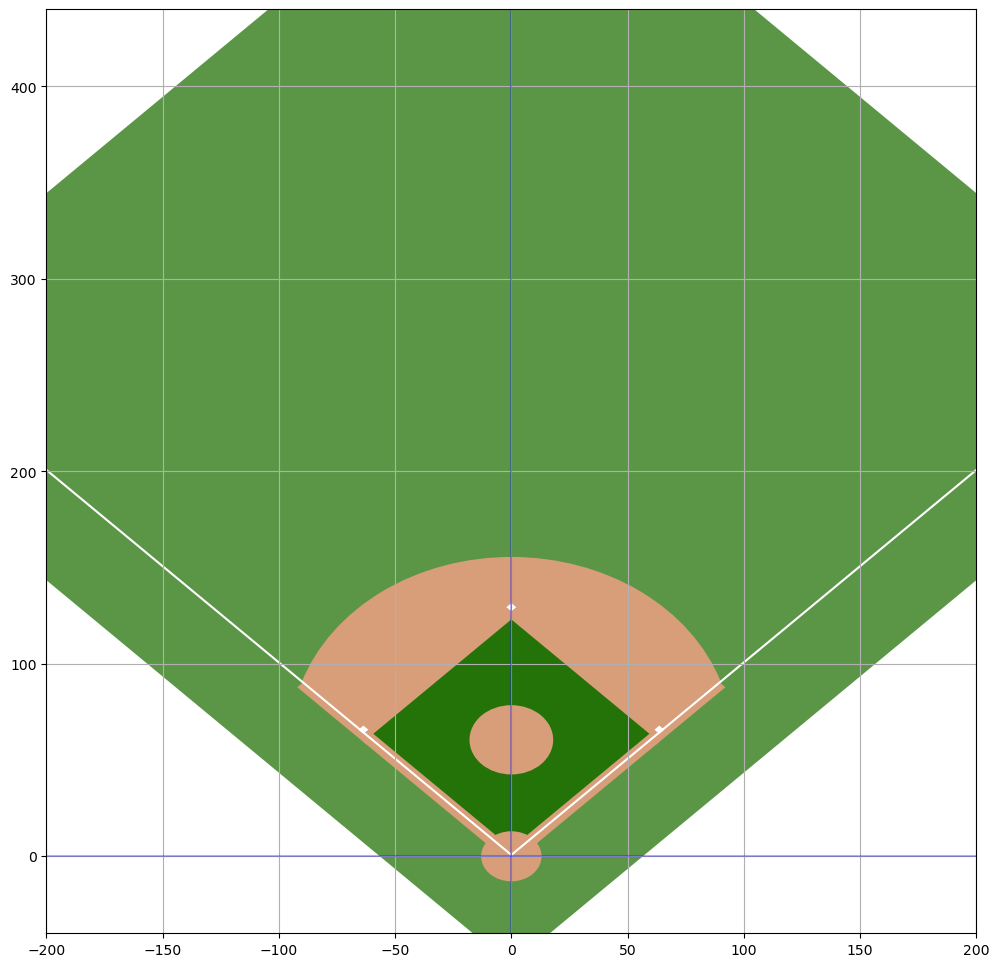

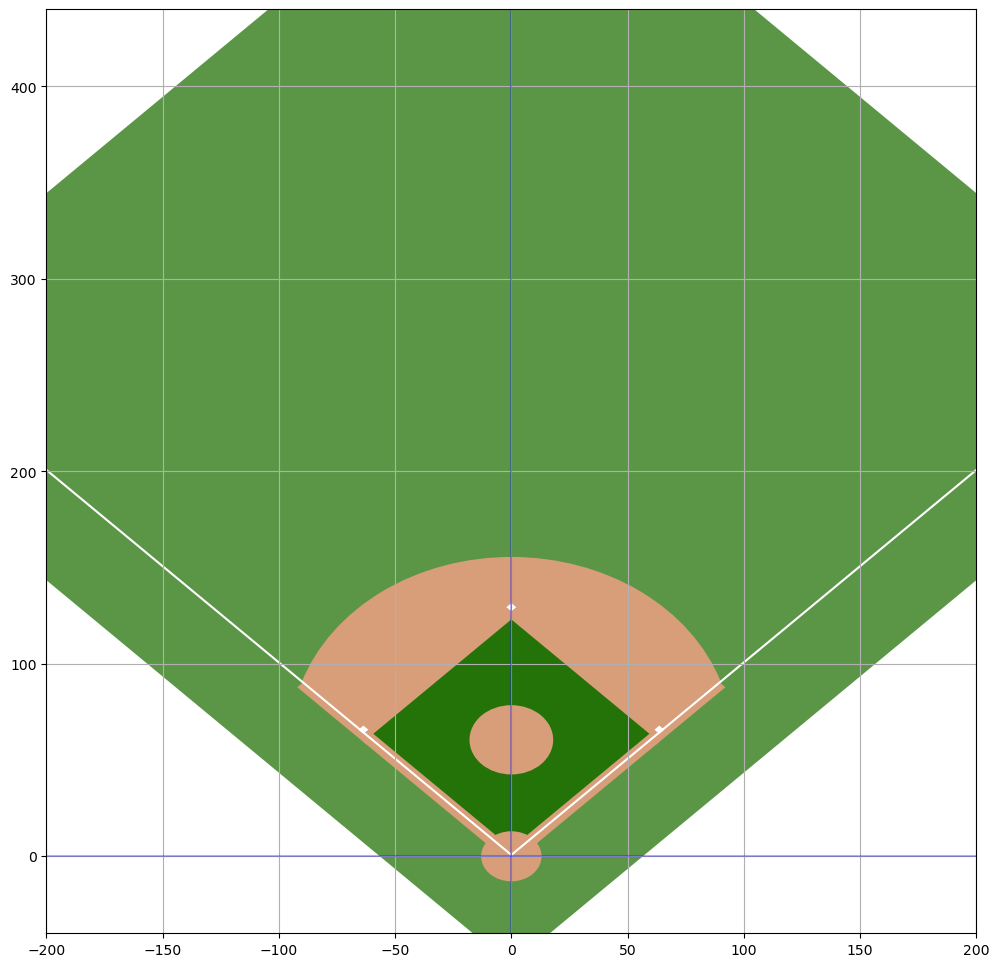

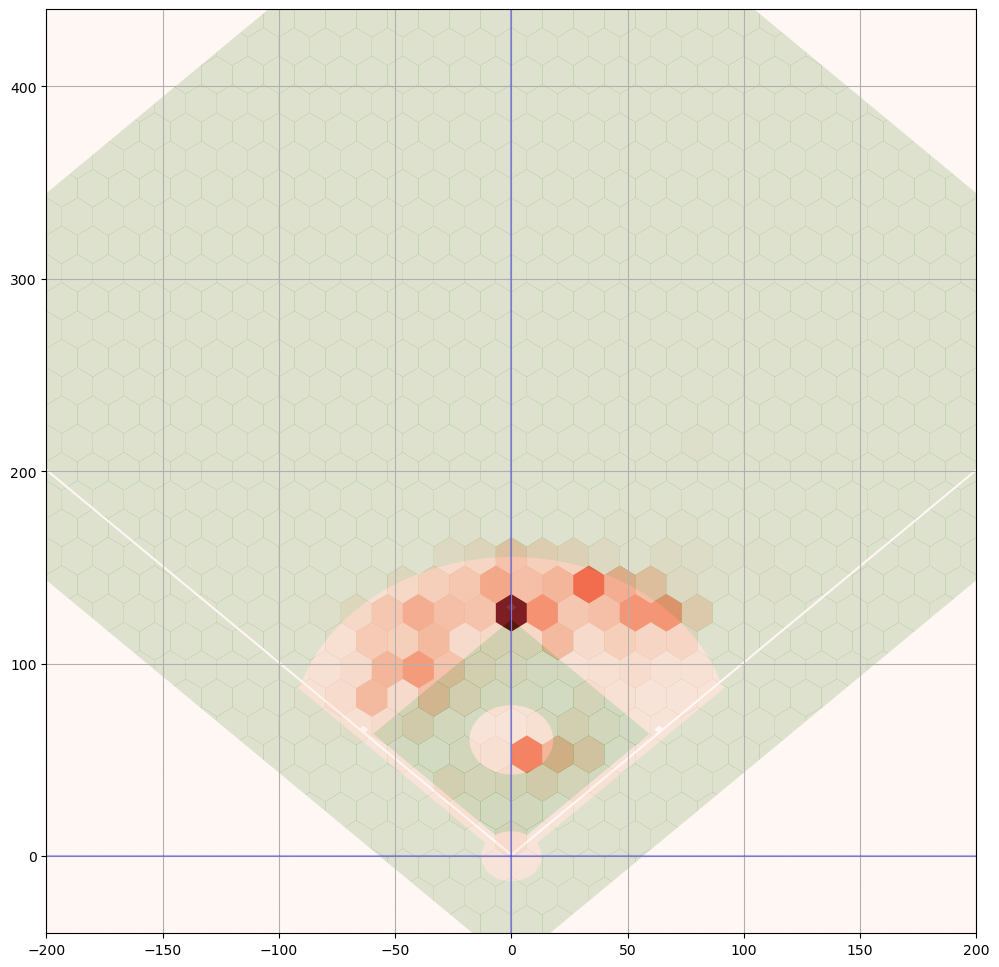

In [24]:
bf.clear_plot()

bf.fig, bf.ax = bf.plot_2d_field()

bf.ax.hexbin(trusted_first_base_out["thrower_x"], 
             trusted_first_base_out["thrower_y"], 
             cmap="Reds", 
             extent = ((-200, 200, -50, 450)),
             edgecolors=None,
             gridsize=30, 
             alpha=0.8) 

plt.show()

#### Throws to first that were not outs

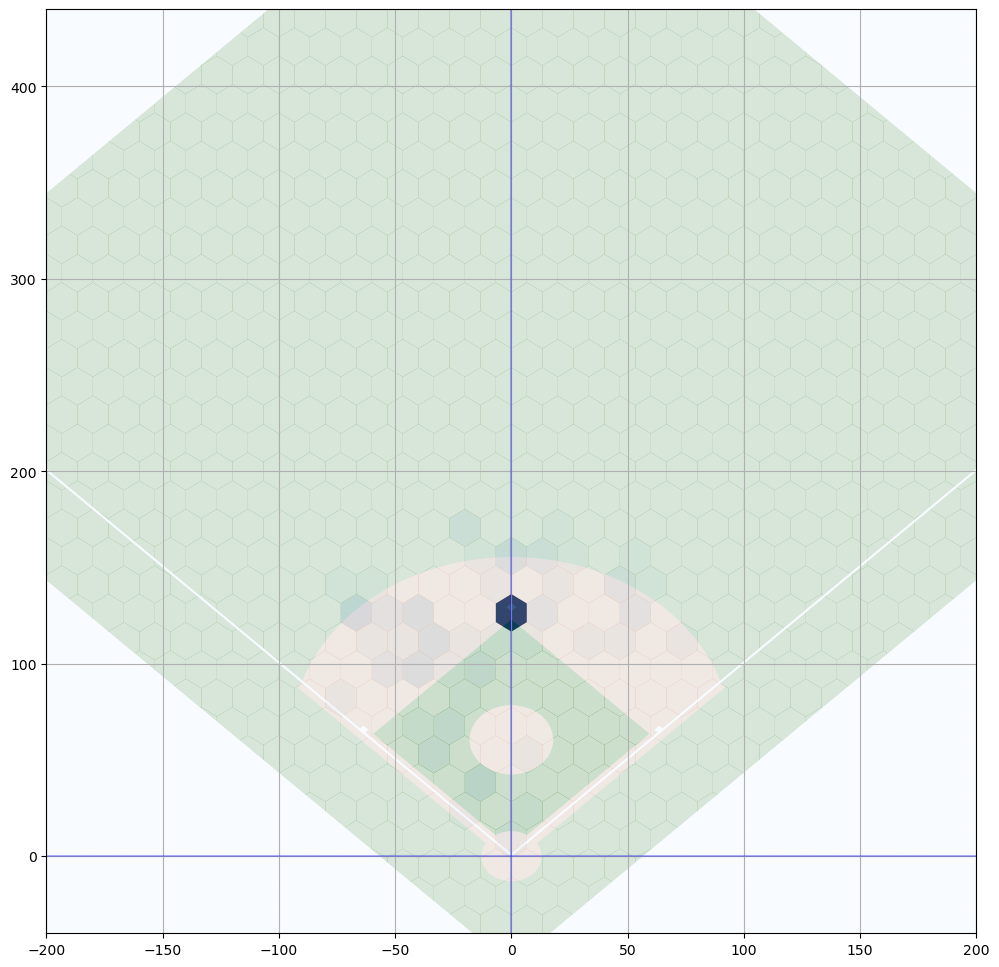

In [25]:
bf.clear_plot()

bf.fig, bf.ax = bf.plot_2d_field()

bf.ax.hexbin(trusted_first_base_not_out["thrower_x"], 
             trusted_first_base_not_out["thrower_y"], 
             cmap="Blues", 
             extent = ((-200, 200, -50, 450)),
             edgecolors=None,
             gridsize=30, 
             alpha=0.8) 

plt.show()



### Batter plots


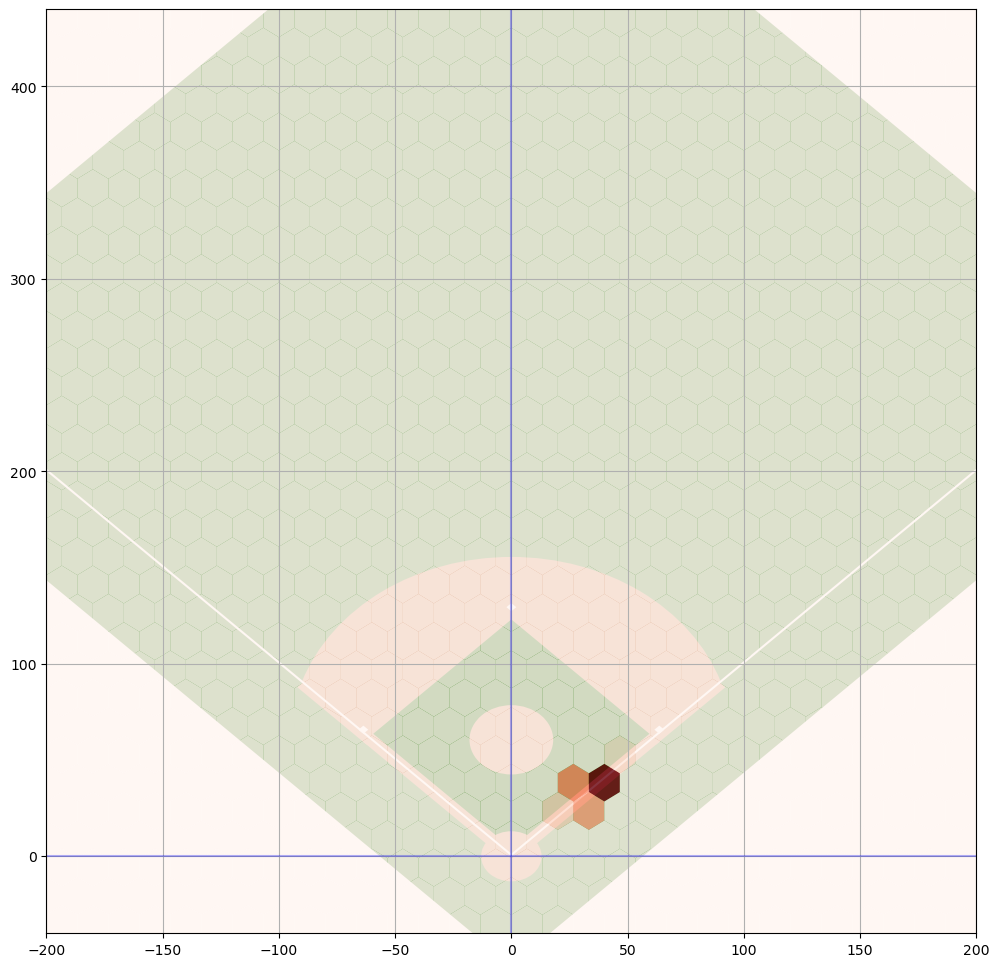

In [26]:
bf.clear_plot()

bf.fig, bf.ax = bf.plot_2d_field()

bf.ax.hexbin(trusted_first_base_out["batter_x"], 
             trusted_first_base_out["batter_y"], 
             cmap="Reds", 
             extent = ((-200, 200, -50, 450)),
             edgecolors=None,
             gridsize=30, 
             alpha=0.8) 

plt.show()


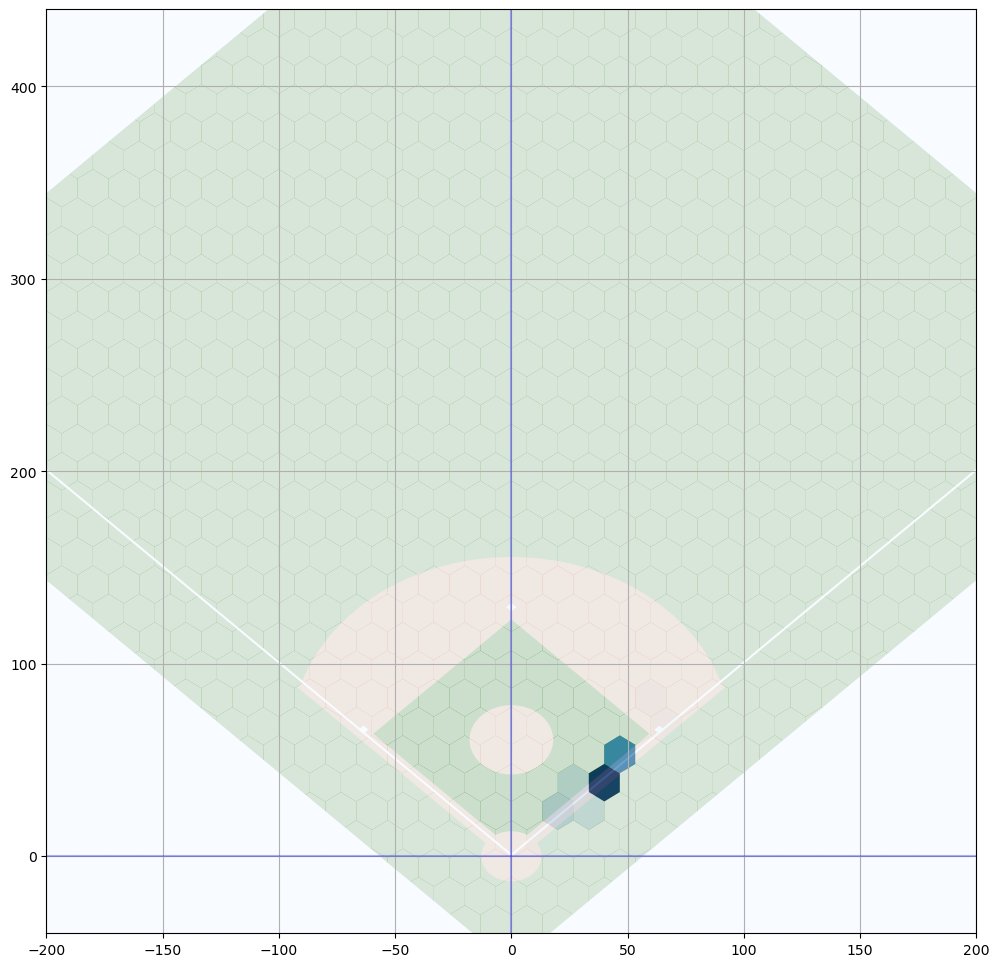

In [27]:
bf.clear_plot()

bf.fig, bf.ax = bf.plot_2d_field()

bf.ax.hexbin(trusted_first_base_not_out["batter_x"], 
             trusted_first_base_not_out["batter_y"], 
             cmap="Blues", 
             extent = ((-200, 200, -50, 450)),
             edgecolors=None,
             gridsize=30, 
             alpha=0.8) 

plt.show()


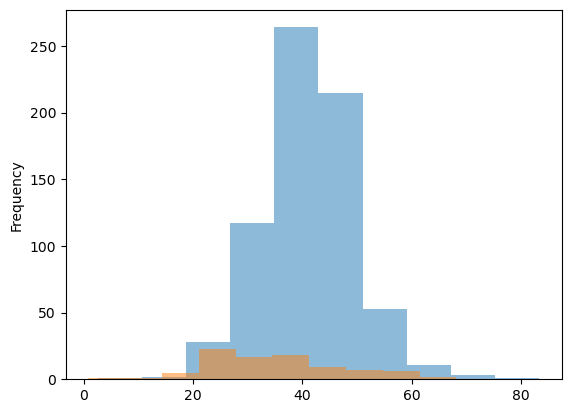

In [28]:
f, a  = plt.subplots()


trusted_first_base_out["batter_dist_to_first"].plot(kind="hist", alpha=0.5, ax=a)
trusted_first_base_not_out["batter_dist_to_first"].plot(kind="hist", alpha=0.5, ax=a)



plt.show()

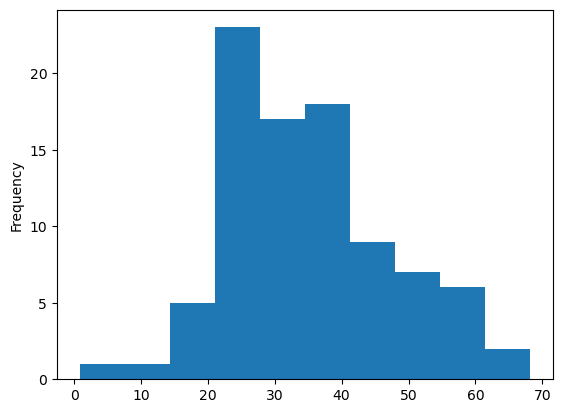

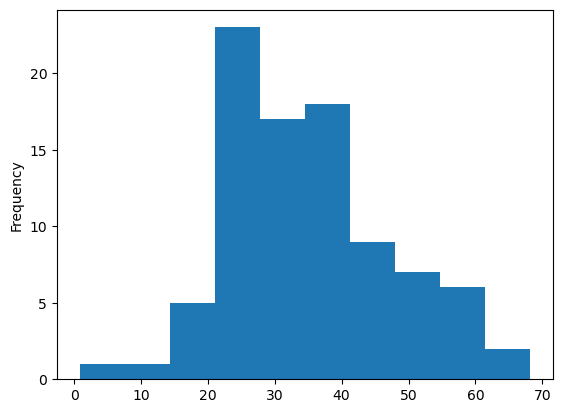

In [30]:
f, a  = plt.subplots()

trusted_first_base_not_out["batter_dist_to_first"].plot(kind="hist", ax=a)

plt.show()


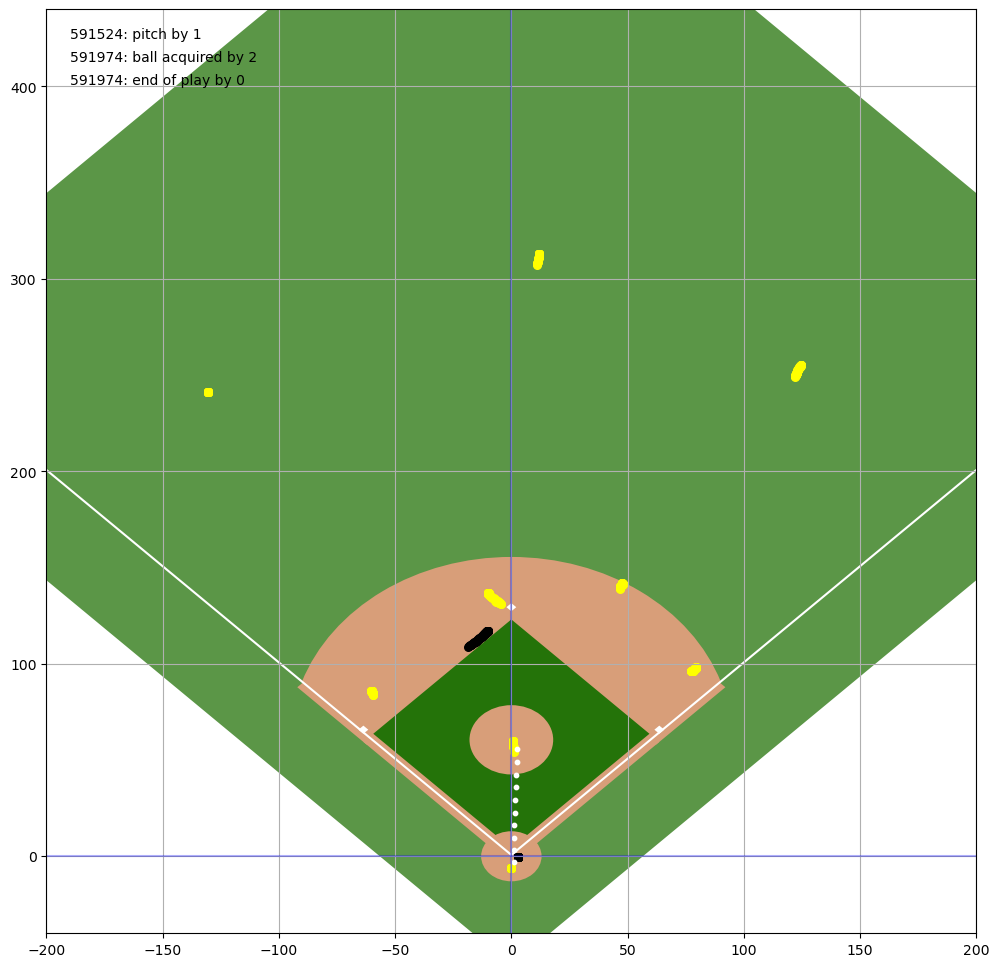

In [ ]:
bf.clear_plot()

play_id = 21# throws.loc[throws["xy_throw_angle"] < 5, :].play_id.iloc[1] # bf_1903_01.game_obj.get_pid_from_ppg(75)

bf.plot_all_components(play_id=play_id)
bf.fig

# bf.create_gif(play_id=play_id, tag="--throw_to_end_play")

## Compute angle features, and make a plot of it!

In [213]:
def load_model_data(file_path="new_model_dataset.csv"):
    
    model_dataset = pd.read_csv(file_path, index_col=0)


    trusted_first_base_out_throws = model_dataset.loc[model_dataset["type"] == "trusted_first_base_out_throws"]
    trusted_first_base_out_receives = model_dataset.loc[model_dataset["type"] == "trusted_first_base_out_receives"]


    combined_outs = trusted_first_base_out_throws.merge(
        trusted_first_base_out_receives,
        on=["game_str", "play_id"],
        how="left",
        suffixes=["_throw", "_receive"]
    )

    combined_outs["target"] = 1


    trusted_first_base_not_out_throws = model_dataset.loc[model_dataset["type"] == "trusted_first_base_not_out_throws"]
    trusted_first_base_not_out_receives = model_dataset.loc[model_dataset["type"] == "trusted_first_base_not_out_receives"]


    combined_not_outs = trusted_first_base_not_out_throws.merge(
        trusted_first_base_not_out_receives,
        on=["game_str", "play_id"],
        how="left",
        suffixes=["_throw", "_receive"]
    )


    combined_not_outs["target"] = 0


    train = pd.concat([combined_outs, combined_not_outs])

    train = train.loc[:, ~train.columns.isin(['play_per_game'])]
    
    return train


In [216]:
train = load_model_data()

### More features? 
- compute a "distance_to_bag" for each throw
- the distance you shorten the throw by?
- percentage of that?
    - I think no
- speed of batter? I think I should def have this one!

In [217]:
train

,game_str,play_id,player_id_throw,player_position_throw,xy_throw_angle_throw,elevation_throw_angle_throw,throw_bounced_throw,throw_velo_throw,batter_dist_to_first_throw,thrower_x_throw,thrower_y_throw,batter_x_throw,batter_y_throw,ball_position_x_throw,ball_position_y_throw,ball_position_z_throw,type_throw,player_id_receive,player_position_receive,xy_throw_angle_receive,elevation_throw_angle_receive,throw_bounced_receive,throw_velo_receive,batter_dist_to_first_receive,thrower_x_receive,thrower_y_receive,batter_x_receive,batter_y_receive,ball_position_x_receive,ball_position_y_receive,ball_position_z_receive,type_receive,target
0,1903_01_TeamNE_TeamA2,10,2053,4,1.962933,2.041084,0,73.227697,47.089984,0.6681,129.3444,29.2554,31.4652,2.444979,126.2148,5.65056,trusted_first_base_out_throws,2526,3,NaN,NaN,0,NaN,23.812321,NaN,NaN,45.9588,47.6892,61.6866,65.9577,2.751036,trusted_first_base_out_receives,1
1,1903_01_TeamNE_TeamA2,18,6000,6,2.714353,3.179570,0,75.066867,45.904246,-1.5081,145.3005,29.9541,32.4549,-0.552351,140.5905,4.82034,trusted_first_base_out_throws,5616,3,NaN,NaN,0,NaN,21.131690,NaN,NaN,47.6973,49.7691,61.9188,67.2186,1.978692,trusted_first_base_out_receives,1
2,1903_01_TeamNE_TeamA2,38,9762,5,1.108531,1.218903,0,84.224138,60.608922,-59.9457,81.2073,20.2293,21.3432,-53.675100,77.8668,6.21342,trusted_first_base_out_throws,5616,3,NaN,NaN,0,NaN,34.131229,NaN,NaN,39.1560,39.8595,62.9247,63.0588,1.043331,trusted_first_base_out_receives,1
3,1903_01_TeamNE_TeamA2,58,1972,6,2.358087,4.034777,0,72.686062,51.954068,-39.4440,125.9001,26.6307,27.1764,-35.535300,121.1655,5.69469,trusted_first_base_out_throws,2526,3,NaN,NaN,0,NaN,23.276346,NaN,NaN,47.2962,47.0661,59.6838,65.3253,2.773476,trusted_first_base_out_receives,1
4,1903_01_TeamNE_TeamA2,117,6000,6,0.396556,5.304049,0,69.206482,45.312076,-34.3332,104.5527,31.2462,31.9560,-33.001500,100.7013,5.71482,trusted_first_base_out_throws,5616,3,NaN,NaN,0,NaN,14.262960,NaN,NaN,53.5767,53.5317,63.2727,59.7609,2.874396,trusted_first_base_out_receives,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1902_21_TeamME_TeamA2,4,1972,6,0.147518,2.631509,1,78.332335,40.821064,-71.2152,130.9263,33.9633,35.6097,-72.999000,129.5985,5.76207,trusted_first_base_not_out_throws,2526,3,NaN,NaN,0,NaN,3.886123,NaN,NaN,66.3687,66.4062,57.0213,61.8360,2.524968,trusted_first_base_not_out_receives,0
85,1902_21_TeamME_TeamA2,174,1643,4,0.306712,3.826896,0,45.232442,34.504695,51.8283,113.0304,39.0219,39.4623,49.949100,112.7673,5.80467,trusted_first_base_not_out_throws,2526,3,NaN,NaN,0,NaN,11.790403,NaN,NaN,54.7785,55.8618,63.4101,63.7401,3.009090,trusted_first_base_not_out_receives,0
86,1901_11_TeamLJ_TeamB,164,9850,4,2.289536,5.714112,0,74.489805,43.632381,16.1676,150.9126,32.6934,32.8806,16.536120,145.6632,4.94382,trusted_first_base_not_out_throws,4723,3,NaN,NaN,0,NaN,18.687589,NaN,NaN,49.9707,50.8965,58.3134,64.9392,7.681620,trusted_first_base_not_out_receives,0
87,1901_11_TeamLJ_TeamB,250,1650,5,0.618487,4.833246,1,68.419111,57.886617,-46.6662,96.4449,21.6360,23.8080,-46.650300,93.4617,4.72704,trusted_first_base_not_out_throws,1334,3,NaN,NaN,0,NaN,28.334657,NaN,NaN,43.3287,43.8831,61.1616,64.5894,0.000000,trusted_first_base_not_out_receives,0


In [224]:
train[["ball_position_x_throw", "ball_position_y_throw", "ball_position_z_throw"]].values[0,: ]

array([  2.444979, 126.2148  ,   5.65056 ])

In [237]:
# refactor this -- should be in player details!

train["dist_from_bag_receive"] = train.apply(
    lambda row:
        row[["ball_position_x_receive", "ball_position_y_receive", "ball_position_z_receive"]].values \
        - np.array([63.63961031, 63.63961031, 0])
    , axis = 1).apply(lambda vect: np.sqrt(vect.dot(vect)))

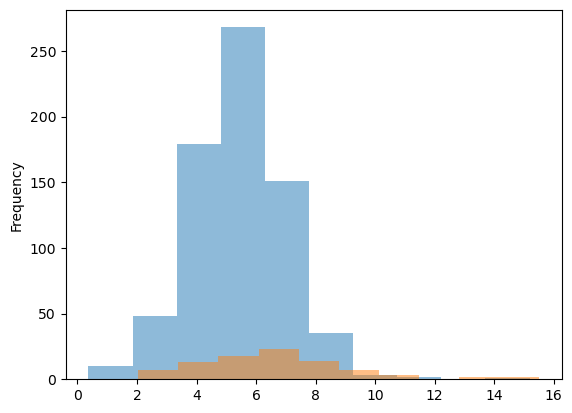

In [249]:
plt.close()

f, a  = plt.subplots()

outs = train.loc[
    train["target"] == 1,
    ["target", "dist_from_bag_receive"]
]


not_outs = train.loc[
    train["target"] == 0,
    ["target", "dist_from_bag_receive"]
]

outs["dist_from_bag_receive"].plot(kind="hist", alpha=0.5, ax=a)
not_outs["dist_from_bag_receive"].plot(kind="hist", alpha=0.5, ax=a)



plt.show()

In [260]:
# which should be pos?

# TURN THIS INTO GAME TOO!

vect_throw_to_bag = train[["ball_position_x_throw", "ball_position_y_throw", "ball_position_z_throw"]].values[0,: ] \
    - np.array([63.63961031, 63.63961031, 0])

vect_throw_to_bag

array([-61.19463131,  62.57518969,   5.65056   ])

In [264]:
vect_receive_to_bag = train[["ball_position_x_receive", "ball_position_y_receive", "ball_position_z_receive"]].values[0,: ] \
    - np.array([63.63961031, 63.63961031, 0])

vect_receive_to_bag

array([-1.95301031,  2.31808969,  2.751036  ])

In [266]:
np.sqrt(vect_receive_to_bag.dot(vect_receive_to_bag))

4.093407890150529

In [268]:
shorten_throw_by_vect = vect_receive_to_bag.dot(vect_throw_to_bag) / vect_throw_to_bag.dot(vect_throw_to_bag) * vect_throw_to_bag 

np.sqrt(shorten_throw_by_vect.dot(shorten_throw_by_vect))

3.1937736433557116

In [280]:
def compute_shorten_throw_by(i):
    vect_throw_to_bag = train[["ball_position_x_throw", "ball_position_y_throw", "ball_position_z_throw"]].values[i,: ] \
        - np.array([63.63961031, 63.63961031, 0])

    vect_receive_to_bag = train[["ball_position_x_receive", "ball_position_y_receive", "ball_position_z_receive"]].values[i,: ] \
        - np.array([63.63961031, 63.63961031, 0])

    shorten_throw_by_vect = vect_receive_to_bag.dot(vect_throw_to_bag) / vect_throw_to_bag.dot(vect_throw_to_bag) * vect_throw_to_bag 

    shortern_throw_by_dist = np.sqrt(shorten_throw_by_vect.dot(shorten_throw_by_vect))
    
    perpendicular_vect = vect_receive_to_bag - shorten_throw_by_vect
    
    perpendicular_dist = np.sqrt(perpendicular_vect.dot(perpendicular_vect))

    
    return shortern_throw_by_dist #, perpendicular_dist
    
    

In [282]:
train["shorten_throw_by"] = list(map(compute_shorten_throw_by, range(train.shape[0])))

In [293]:
train

,game_str,play_id,player_id_throw,player_position_throw,xy_throw_angle_throw,elevation_throw_angle_throw,throw_bounced_throw,throw_velo_throw,batter_dist_to_first_throw,thrower_x_throw,thrower_y_throw,batter_x_throw,batter_y_throw,ball_position_x_throw,ball_position_y_throw,ball_position_z_throw,type_throw,player_id_receive,player_position_receive,xy_throw_angle_receive,elevation_throw_angle_receive,throw_bounced_receive,throw_velo_receive,batter_dist_to_first_receive,thrower_x_receive,thrower_y_receive,batter_x_receive,batter_y_receive,ball_position_x_receive,ball_position_y_receive,ball_position_z_receive,type_receive,target,dist_from_bag_receive,shorten_throw_by
0,1903_01_TeamNE_TeamA2,10,2053,4,1.962933,2.041084,0,73.227697,47.089984,0.6681,129.3444,29.2554,31.4652,2.444979,126.2148,5.65056,trusted_first_base_out_throws,2526,3,NaN,NaN,0,NaN,23.812321,NaN,NaN,45.9588,47.6892,61.6866,65.9577,2.751036,trusted_first_base_out_receives,1,4.093408,3.193774
1,1903_01_TeamNE_TeamA2,18,6000,6,2.714353,3.179570,0,75.066867,45.904246,-1.5081,145.3005,29.9541,32.4549,-0.552351,140.5905,4.82034,trusted_first_base_out_throws,5616,3,NaN,NaN,0,NaN,21.131690,NaN,NaN,47.6973,49.7691,61.9188,67.2186,1.978692,trusted_first_base_out_receives,1,4.436843,3.941222
2,1903_01_TeamNE_TeamA2,38,9762,5,1.108531,1.218903,0,84.224138,60.608922,-59.9457,81.2073,20.2293,21.3432,-53.675100,77.8668,6.21342,trusted_first_base_out_throws,5616,3,NaN,NaN,0,NaN,34.131229,NaN,NaN,39.1560,39.8595,62.9247,63.0588,1.043331,trusted_first_base_out_receives,1,1.391753,0.693684
3,1903_01_TeamNE_TeamA2,58,1972,6,2.358087,4.034777,0,72.686062,51.954068,-39.4440,125.9001,26.6307,27.1764,-35.535300,121.1655,5.69469,trusted_first_base_out_throws,2526,3,NaN,NaN,0,NaN,23.276346,NaN,NaN,47.2962,47.0661,59.6838,65.3253,2.773476,trusted_first_base_out_receives,1,5.116850,4.399956
4,1903_01_TeamNE_TeamA2,117,6000,6,0.396556,5.304049,0,69.206482,45.312076,-34.3332,104.5527,31.2462,31.9560,-33.001500,100.7013,5.71482,trusted_first_base_out_throws,5616,3,NaN,NaN,0,NaN,14.262960,NaN,NaN,53.5767,53.5317,63.2727,59.7609,2.874396,trusted_first_base_out_receives,1,4.841608,0.886213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1902_21_TeamME_TeamA2,4,1972,6,0.147518,2.631509,1,78.332335,40.821064,-71.2152,130.9263,33.9633,35.6097,-72.999000,129.5985,5.76207,trusted_first_base_not_out_throws,2526,3,NaN,NaN,0,NaN,3.886123,NaN,NaN,66.3687,66.4062,57.0213,61.8360,2.524968,trusted_first_base_not_out_receives,0,7.309617,5.268227
85,1902_21_TeamME_TeamA2,174,1643,4,0.306712,3.826896,0,45.232442,34.504695,51.8283,113.0304,39.0219,39.4623,49.949100,112.7673,5.80467,trusted_first_base_not_out_throws,2526,3,NaN,NaN,0,NaN,11.790403,NaN,NaN,54.7785,55.8618,63.4101,63.7401,3.009090,trusted_first_base_not_out_receives,0,3.019503,0.497687
86,1901_11_TeamLJ_TeamB,164,9850,4,2.289536,5.714112,0,74.489805,43.632381,16.1676,150.9126,32.6934,32.8806,16.536120,145.6632,4.94382,trusted_first_base_not_out_throws,4723,3,NaN,NaN,0,NaN,18.687589,NaN,NaN,49.9707,50.8965,58.3134,64.9392,7.681620,trusted_first_base_not_out_receives,0,9.437411,4.175200
87,1901_11_TeamLJ_TeamB,250,1650,5,0.618487,4.833246,1,68.419111,57.886617,-46.6662,96.4449,21.6360,23.8080,-46.650300,93.4617,4.72704,trusted_first_base_not_out_throws,1334,3,NaN,NaN,0,NaN,28.334657,NaN,NaN,43.3287,43.8831,61.1616,64.5894,0.000000,trusted_first_base_not_out_receives,0,2.653796,2.637764


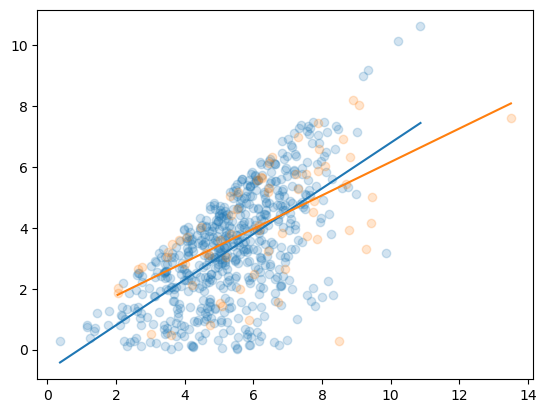

In [299]:
plt.close()

f, a  = plt.subplots()

outs = train.loc[
    (train["target"] == 1) &
    (train["xy_throw_angle_throw"] < 3),
    ["target", "dist_from_bag_receive", "shorten_throw_by"]
].dropna(inplace=False)


not_outs = train.loc[
    (train["target"] == 0) &
    (train["xy_throw_angle_throw"] < 3),
    ["target", "dist_from_bag_receive", "shorten_throw_by"]
].dropna(inplace=False)

a.scatter(outs["dist_from_bag_receive"], outs["shorten_throw_by"], marker="o", alpha=0.2)

a.scatter(not_outs["dist_from_bag_receive"], not_outs["shorten_throw_by"], marker="o", alpha=0.2)


a.plot(np.unique(outs["dist_from_bag_receive"]), np.poly1d(np.polyfit(outs["dist_from_bag_receive"], outs["shorten_throw_by"], 1))(np.unique(outs["dist_from_bag_receive"])))

a.plot(np.unique(not_outs["dist_from_bag_receive"]), np.poly1d(np.polyfit(not_outs["dist_from_bag_receive"], not_outs["shorten_throw_by"], 1))(np.unique(not_outs["dist_from_bag_receive"])))


plt.show()

**THIS IS A REALLY INTERESTING FINDING**

I think the slope means that on average, outs are more efficient at shortening the distance the ball needs to travel

That should be fairly obvious, but I also control for the angle of the throw!
- maybe there is a view that shows for on line throw whether this is still true?
    - It is! 3 degrees is shows this pretty well!

In [ ]:

# make a vector from the first point to the target point
xy_vect_to_target = target_point - a[["ball_position_x", "ball_position_y"]].iloc[0].values

# scale it to be a unit vector
unit_xy_vect_to_target = xy_vect_to_target / np.sqrt(xy_vect_to_target.dot(xy_vect_to_target))

# Maybe the whole window so we don't get noise?
throw_velo_xy_vect = a[["ball_position_x", "ball_position_y"]].iloc[-1].values \
    - a[["ball_position_x", "ball_position_y"]].iloc[0].values

# the other one is a unit vect, so we don't need to divide here
xy_angle_to_first_rad = np.arccos(throw_velo_xy_vect.dot(unit_xy_vect_to_target) / np.sqrt(throw_velo_xy_vect.dot(throw_velo_xy_vect)))

xy_angle_to_first_deg = xy_angle_to_first_rad * 180 / np.pi

# hmm there are some times where you might want to miss the bag -- e.g. throws from catcher! 



## Try to build some Models

In [101]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB
from scipy.special import expit
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split, StratifiedGroupKFold


from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    mean_squared_error,
    precision_score,
    recall_score,
    roc_auc_score,
)

from collections import defaultdict


In [215]:
train = load_model_data()

In [103]:
train.head()

,game_str,play_id,player_id_throw,player_position_throw,xy_throw_angle_throw,elevation_throw_angle_throw,throw_bounced_throw,throw_velo_throw,batter_dist_to_first_throw,thrower_x_throw,thrower_y_throw,batter_x_throw,batter_y_throw,ball_position_x_throw,ball_position_y_throw,ball_position_z_throw,type_throw,player_id_receive,player_position_receive,xy_throw_angle_receive,elevation_throw_angle_receive,throw_bounced_receive,throw_velo_receive,batter_dist_to_first_receive,thrower_x_receive,thrower_y_receive,batter_x_receive,batter_y_receive,ball_position_x_receive,ball_position_y_receive,ball_position_z_receive,type_receive,target
0,1903_01_TeamNE_TeamA2,10,2053,4,1.962933,2.041084,0,73.227697,47.089984,0.6681,129.3444,29.2554,31.4652,2.444979,126.2148,5.65056,trusted_first_base_out_throws,2526,3,NaN,NaN,0,NaN,23.812321,NaN,NaN,45.9588,47.6892,61.6866,65.9577,2.751036,trusted_first_base_out_receives,1
1,1903_01_TeamNE_TeamA2,18,6000,6,2.714353,3.179570,0,75.066867,45.904246,-1.5081,145.3005,29.9541,32.4549,-0.552351,140.5905,4.82034,trusted_first_base_out_throws,5616,3,NaN,NaN,0,NaN,21.131690,NaN,NaN,47.6973,49.7691,61.9188,67.2186,1.978692,trusted_first_base_out_receives,1
2,1903_01_TeamNE_TeamA2,38,9762,5,1.108531,1.218903,0,84.224138,60.608922,-59.9457,81.2073,20.2293,21.3432,-53.675100,77.8668,6.21342,trusted_first_base_out_throws,5616,3,NaN,NaN,0,NaN,34.131229,NaN,NaN,39.1560,39.8595,62.9247,63.0588,1.043331,trusted_first_base_out_receives,1
3,1903_01_TeamNE_TeamA2,58,1972,6,2.358087,4.034777,0,72.686062,51.954068,-39.4440,125.9001,26.6307,27.1764,-35.535300,121.1655,5.69469,trusted_first_base_out_throws,2526,3,NaN,NaN,0,NaN,23.276346,NaN,NaN,47.2962,47.0661,59.6838,65.3253,2.773476,trusted_first_base_out_receives,1
4,1903_01_TeamNE_TeamA2,117,6000,6,0.396556,5.304049,0,69.206482,45.312076,-34.3332,104.5527,31.2462,31.9560,-33.001500,100.7013,5.71482,trusted_first_base_out_throws,5616,3,NaN,NaN,0,NaN,14.262960,NaN,NaN,53.5767,53.5317,63.2727,59.7609,2.874396,trusted_first_base_out_receives,1


In [104]:
train.columns

Index(['game_str', 'play_id', 'player_id_throw', 'player_position_throw',
       'xy_throw_angle_throw', 'elevation_throw_angle_throw',
       'throw_bounced_throw', 'throw_velo_throw', 'batter_dist_to_first_throw',
       'thrower_x_throw', 'thrower_y_throw', 'batter_x_throw',
       'batter_y_throw', 'ball_position_x_throw', 'ball_position_y_throw',
       'ball_position_z_throw', 'type_throw', 'player_id_receive',
       'player_position_receive', 'xy_throw_angle_receive',
       'elevation_throw_angle_receive', 'throw_bounced_receive',
       'throw_velo_receive', 'batter_dist_to_first_receive',
       'thrower_x_receive', 'thrower_y_receive', 'batter_x_receive',
       'batter_y_receive', 'ball_position_x_receive',
       'ball_position_y_receive', 'ball_position_z_receive', 'type_receive',
       'target'],
      dtype='object')

In [158]:
all_cols_for_training = ['xy_throw_angle_throw', 'elevation_throw_angle_throw', 'throw_velo_throw', 'throw_bounced_throw', 'batter_dist_to_first_throw', 
                     'thrower_x_throw', 'thrower_y_throw', 'batter_x_throw', 'batter_y_throw', 'ball_position_x_receive', 'ball_position_y_receive', 'ball_position_z_receive'
             ]

#cols_for_training =  ['ball_position_x_receive', 'ball_position_y_receive', 'ball_position_z_receive', 'batter_y_receive']

In [195]:
X = train[all_cols_for_training].dropna()
y = train[all_cols_for_training + ["target"]].dropna()["target"]
player_ids = train[all_cols_for_training  + ["player_id_receive"]].dropna()["player_id_receive"]

game_strs = train[all_cols_for_training  + ["game_str"]].dropna()["game_str"]
play_ids = train[all_cols_for_training  + ["play_id"]].dropna()["play_id"]


In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.5, random_state=10) #test_size=0.5, random_state=10)

#### Feature Selection

-  Wasserman, L. (2013). All of Statistics: A Concise Course in Statistical Inference. Springer Science & Business Media. 
    - for the inspo on the F tests
- Maybe pick different models, stats tests

In [157]:
from scipy import stats

In [170]:

col_subset = ['xy_throw_angle_throw', 'elevation_throw_angle_throw', 'throw_velo_throw', 'throw_bounced_throw', 'batter_dist_to_first_throw', 'batter_x_throw', 'batter_y_throw', 'ball_position_x_receive', 'ball_position_y_receive', 'ball_position_z_receive']


model_1 = LogisticRegression(C=1e3,  max_iter=1000)
model_1.fit(X_train[col_subset], y_train)
residuals_1 = model_1.predict(X_test[col_subset]) - y_test


model_2 = LogisticRegression(C=1e3,  max_iter=1000)
model_2.fit(X_train, y_train)
residuals_2 = model_2.predict(X_test) - y_test



In [171]:
# compute sum of squared residuals
rss_1 = sum([r**2 for r in residuals_1])
rss_2 = sum([r**2 for r in residuals_2])

# number of params in each
k_1, k_2 = len(col_subset), len(X_train.columns)

# number of samples
n = len(residuals_1)

In [172]:
# compute the F statistic
F = ((rss_1 - rss_2) / (k_2 - k_1)) / (rss_2 / (n - k_2))

1 - stats.f.cdf(F, k_2-k_1, n-k_2)

6.27998431035337e-10

#### Model Selection

In [ ]:
## USE StratifiedGroupKFold!!!

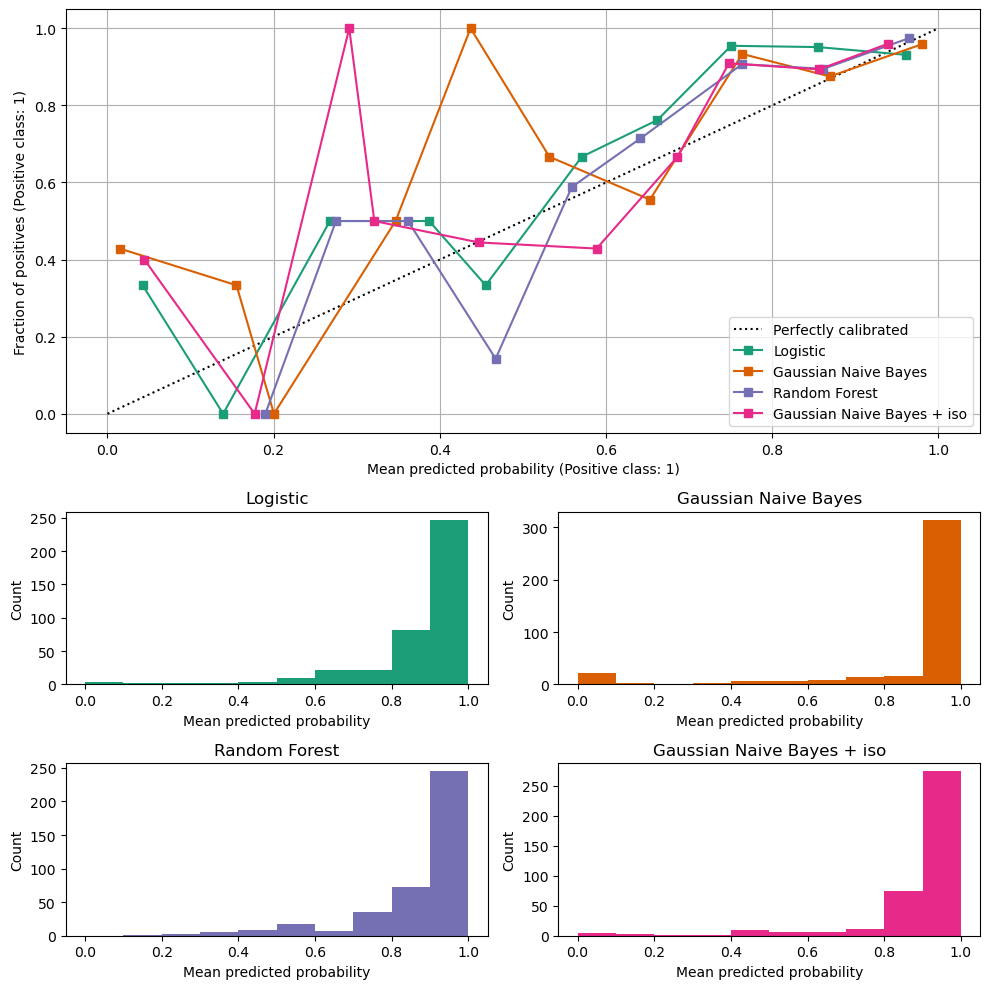

In [154]:
lr = LogisticRegression(C=1e3,  max_iter=1000)

dtc = DecisionTreeClassifier(max_depth=2)

gbc = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0,
    loss='log_loss'
)

rfc = RandomForestClassifier()

gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=3, method="isotonic")

clf_list = [
    (lr, "Logistic"),
    (gnb, "Gaussian Naive Bayes"),
    (rfc, "Random Forest"),
    #(gbc, "Gradient Boosted"),
    #(dtc, "Decision Tree"),
    (gnb_isotonic, "Gaussian Naive Bayes + iso"),
    
]


fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()


# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()




In [156]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score, mean_squared_error]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Roc auc,Mean squared error,Precision,Recall,F1
Classifier,,,,,,,
Logistic,0.079676,0.306465,0.697999,0.079676,0.921260,0.988732,0.953804
Gaussian Naive Bayes,0.080309,0.487788,0.812083,0.080309,0.938889,0.952113,0.945455
Random Forest,0.068821,0.412641,0.803855,0.068821,0.925729,0.983099,0.953552
Gaussian Naive Bayes + iso,0.069646,0.337940,0.808043,0.069646,0.930295,0.977465,0.953297


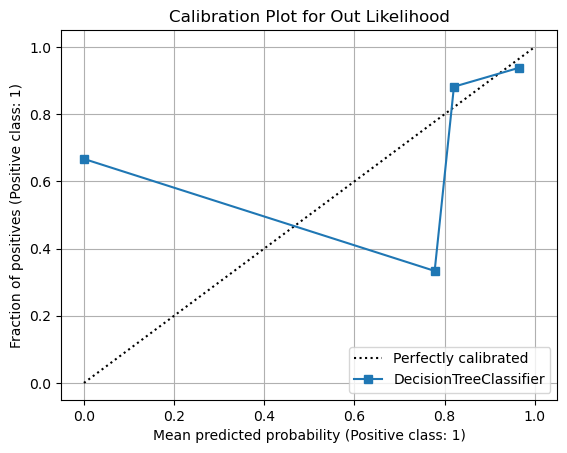

In [99]:
dtr = DecisionTreeClassifier(max_depth=6)


dtr.fit(X_train, y_train)

plt.close()

CalibrationDisplay.from_estimator(
    dtr,
    X_test,
    y_test,
    n_bins = 10,
) 
plt.title("Calibration Plot for Out Likelihood")

plt.grid()
plt.show()

In [50]:
scores = defaultdict(list)

dtr.fit(X_train, y_train)
y_prob = dtr.predict_proba(X_test)
y_pred = dtr.predict(X_test)

for metric in [brier_score_loss, log_loss, roc_auc_score, mean_squared_error]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

pd.DataFrame(scores)

,Brier loss,Log loss,Roc auc
0,0.082697,0.714979,0.650166


/Users/mattnicholson/anaconda3/envs/smt-data-challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


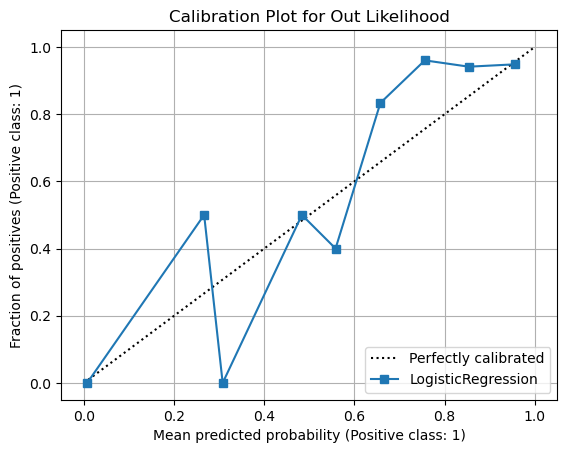

In [51]:
clf = LogisticRegression(C=1000)

clf.fit(X_train, y_train)

plt.close()

CalibrationDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    n_bins = 10,
) 
plt.title("Calibration Plot for Out Likelihood")

plt.grid()
plt.show()


In [52]:
from collections import defaultdict
scores = defaultdict(list)

clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

for metric in [brier_score_loss, log_loss, roc_auc_score, mean_squared_error]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

pd.DataFrame(scores)

/Users/mattnicholson/anaconda3/envs/smt-data-challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Brier loss,Log loss,Roc auc
0,0.070951,0.269556,0.743743


In [54]:
lr = LogisticRegression(C=1e5)

dtr = DecisionTreeRegressor(max_depth=3)

gbr = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0,
    loss='squared_error'
)

clf_list = [
    (lr, "Logistic"),
    (gbr, "Gradient Boosted"),
    (dtr, "Decision Tree Regressor")
]

NameError: name 'DecisionTreeRegressor' is not defined

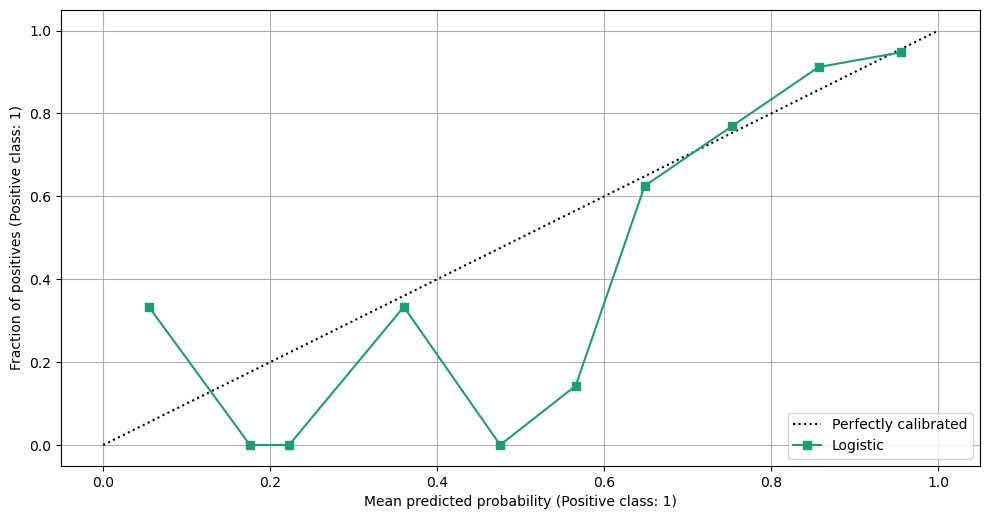

In [55]:


fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X, y)
    display = CalibrationDisplay.from_estimator(
        clf,
        X,
        y,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()


plt.tight_layout()
plt.show()

In [56]:
clf = LogisticRegression(C=1e5)
clf.fit(X, y.values.ravel())

/Users/mattnicholson/anaconda3/envs/smt-data-challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100000.0)

In [57]:
clf.coef_

array([[-0.3881022 ,  0.06741969,  0.0399106 , -1.10903487,  0.03648108,
         0.03284176, -0.02083537,  0.01838898, -0.12934532,  0.01881595,
         0.07044286, -0.18631089]])

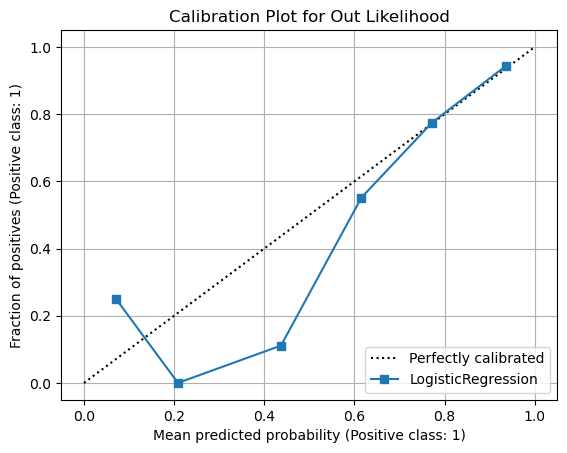

In [210]:
plt.close()

CalibrationDisplay.from_estimator(
    clf,
    X,
    y,
    n_bins = 6,
) 
plt.title("Calibration Plot for Out Likelihood")

plt.grid()
plt.show()

In [211]:
scores = defaultdict(list)

clf.fit(X, y)
y_prob = clf.predict_proba(X)
y_pred = clf.predict(X)

for metric in [brier_score_loss, log_loss, roc_auc_score, mean_squared_error]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y, y_prob[:, 1]))

In [60]:
pd.DataFrame(scores)

,Brier loss,Log loss,Roc auc
0,0.080402,0.293044,0.766806


### Do the prediction and compute the "scores" for each player, with the n

In [205]:
full_data = X.copy()

#clf = RandomForestClassifier()
clf = LogisticRegression(C=1000, max_iter=1000)

clf.fit(X, y)


full_data["predicted_prob"] = clf.predict_proba(X)[:, 1]
full_data["target"] = y
full_data["receiver_id"] = player_ids
full_data["game_str"] = game_strs
full_data["play_id"] = play_ids


full_data["scoops_scores"] = full_data.apply(
    lambda row: row["target"] * 1 - row["predicted_prob"], 
    axis = 1
)


In [212]:
full_data.sort_values(by="scoops_scores", ascending=True)[:50]


## print this as a csv, use this to remap labels!

full_data.sort_values(by="scoops_scores", ascending=True).to_csv("logisitc_predicted_scoop_scores.csv")

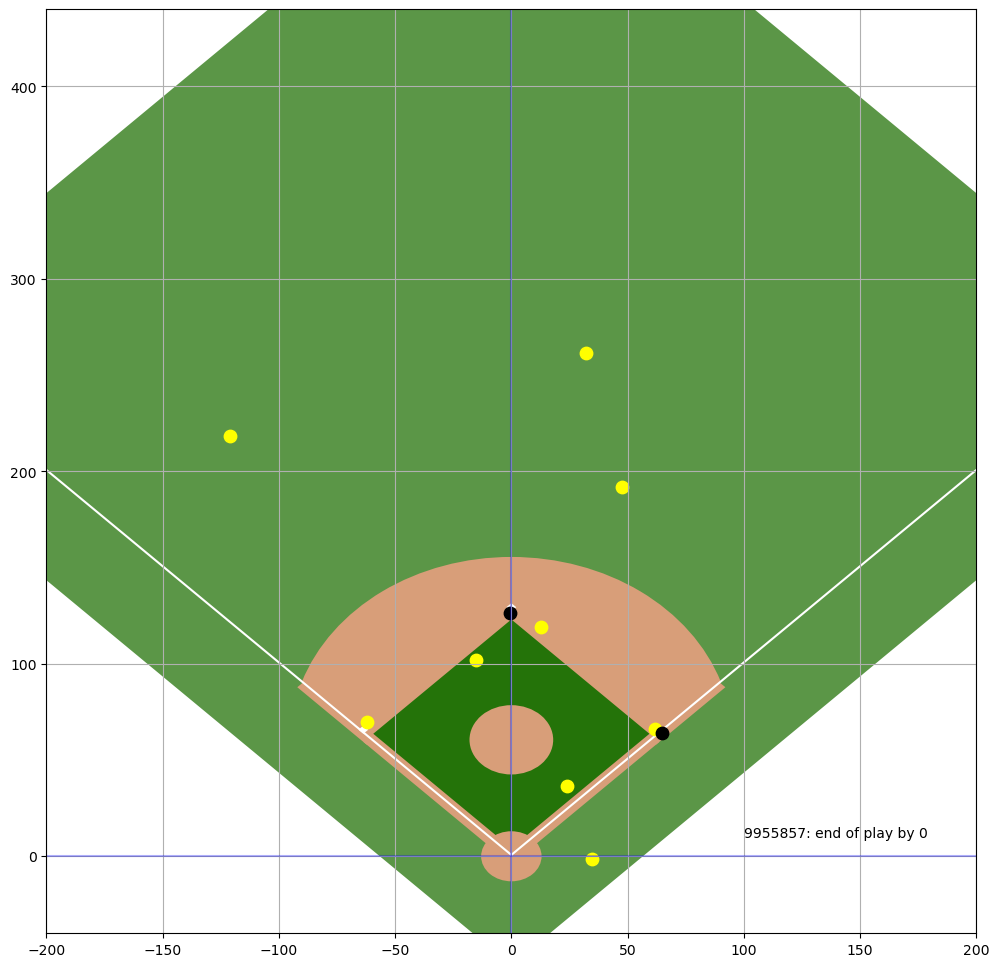

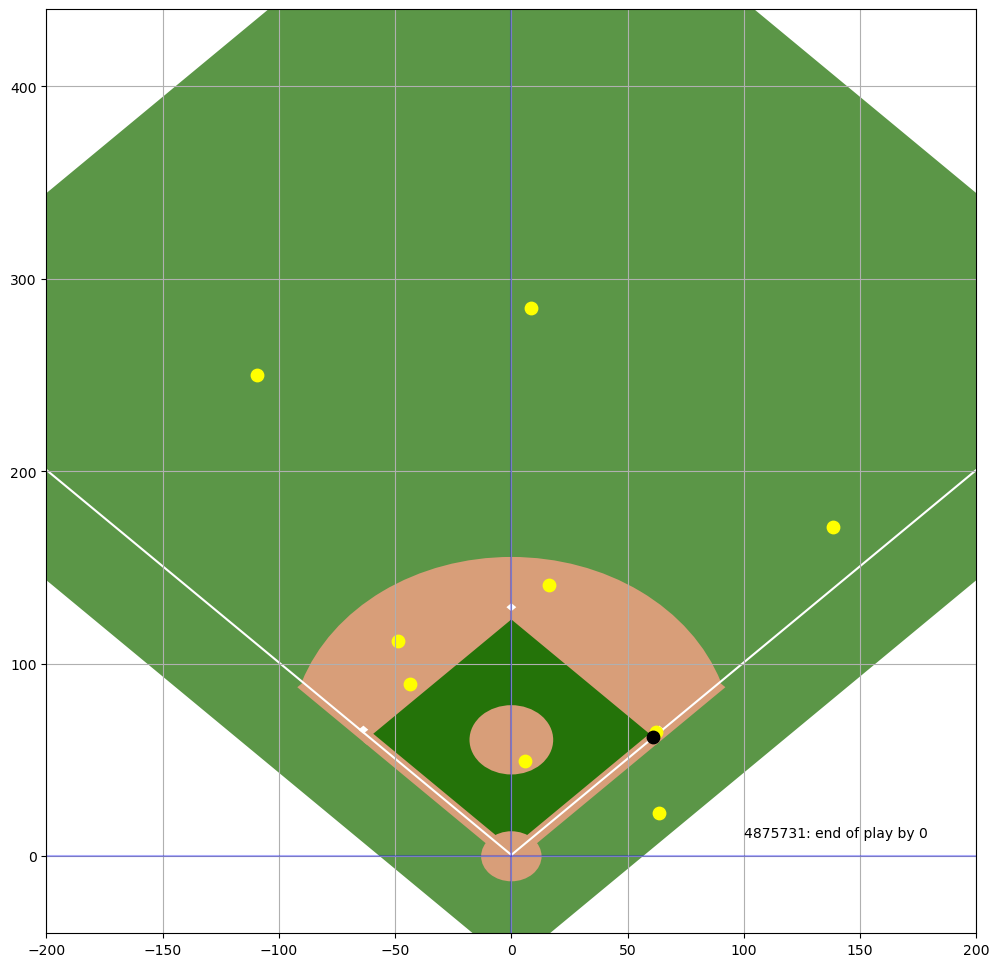

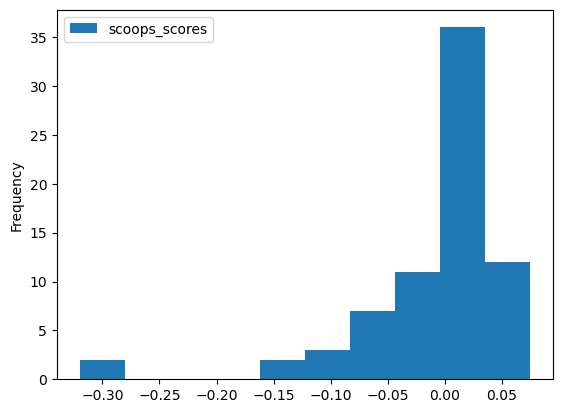

In [201]:
# can slice this up a bunch of different ways
# - by year, by player, by level, etc

cols = ["receiver_id", "scoops_scores"]

full_data[cols].groupby("receiver_id").mean().plot(kind="hist")

plt.show()

In [202]:
cols = ["receiver_id", "scoops_scores"]
# mean_scoops_score = full_data["scoops_scores"].mean()


full_data[cols].groupby("receiver_id").describe().sort_values(by = ("scoops_scores", "count"), ascending=False)

scoops_scores                                                  
                    count      mean       std   min   25%   50%   75%   max
receiver_id                                                                
1918                 68.0 -0.011765  0.098222 -0.42  0.00  0.01  0.02  0.14
2526                 64.0  0.014219  0.129195 -0.40  0.00  0.03  0.06  0.27
2480                 50.0  0.011400  0.072111 -0.29  0.01  0.02  0.04  0.12
1009                 30.0 -0.011000  0.127721 -0.46  0.00  0.01  0.04  0.18
1784                 27.0  0.018889  0.078561 -0.23  0.00  0.01  0.02  0.32
...                   ...       ...       ...   ...   ...   ...   ...   ...
6672                  1.0 -0.320000       NaN -0.32 -0.32 -0.32 -0.32 -0.32
6240                  1.0  0.000000       NaN  0.00  0.00  0.00  0.00  0.00
5953                  1.0  0.040000       NaN  0.04  0.04  0.04  0.04  0.04
1297                  1.0 -0.320000       NaN -0.32 -0.32 -0.32 -0.32 -0.32
6424                  1.0  0.050000       NaN  0.05  0.05  0.05  0.05  0.05

[73 rows x 8 columns]

In [203]:
full_data.loc[
    full_data["receiver_id"] == 1918

].sort_values(by="scoops_scores", ascending=False)

,xy_throw_angle_throw,elevation_throw_angle_throw,throw_velo_throw,throw_bounced_throw,batter_dist_to_first_throw,thrower_x_throw,thrower_y_throw,batter_x_throw,batter_y_throw,ball_position_x_receive,ball_position_y_receive,ball_position_z_receive,predicted_prob,target,receiver_id,game_str,play_id,scoops_scores
434,1.524651,2.193063,71.695466,0,25.803042,-2.4699,105.7677,45.2535,45.5358,64.0242,63.8775,4.223910,0.86,1,1918,1903_20_TeamNL_TeamB,188,0.14
497,2.678390,-4.241644,45.099342,1,43.271350,7.1025,53.2536,31.7436,34.3983,61.6842,63.1008,2.766063,0.87,1,1918,1903_25_TeamNK_TeamB,32,0.13
627,0.490239,4.887987,79.106297,0,55.326785,-52.3917,100.5672,23.6037,25.4535,61.9083,59.3868,3.642120,0.91,1,1918,1903_21_TeamNL_TeamB,36,0.09
537,3.779308,1.936811,46.239837,0,29.671616,69.1005,102.3990,43.7349,41.6349,62.9250,67.6386,4.988730,0.91,1,1918,1902_07_TeamMJ_TeamB,180,0.09
433,0.818197,4.303472,76.782000,0,37.843179,0.3489,128.6229,37.1412,36.6222,57.4515,72.3762,1.871415,0.92,1,1918,1903_20_TeamNL_TeamB,159,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,3.845342,5.531898,61.914041,0,32.111503,7.6080,160.0713,41.0163,40.8507,53.9439,60.1566,1.847523,0.20,0,1918,1902_13_TeamMK_TeamB,4,-0.20
79,3.040579,2.170797,47.990069,0,32.526035,64.1325,138.0540,40.1601,41.1306,64.3587,51.4704,5.291460,0.21,0,1918,1902_08_TeamMJ_TeamB,316,-0.21
73,1.819536,5.527197,66.865727,0,60.668418,4.6719,127.1148,20.9238,20.5581,57.8037,66.0291,5.058630,0.27,0,1918,1903_25_TeamNK_TeamB,126,-0.27
61,1.256422,4.771230,76.530880,0,46.929035,-42.5583,127.7166,28.4967,32.5380,60.2616,63.8838,3.132840,0.38,0,1918,1902_13_TeamMK_TeamB,112,-0.38


## Something is wrong with these labels, but explore some plays

In [179]:
bf = Baseball_Field("1903_18_TeamNI_TeamA3", which_outs=["at_first"])

g_info = bf.game_obj.game_info_df.copy()
g_events = bf.game_obj.game_events_df.copy()


In [180]:
bf.clear_plot()


In [182]:
bf.clear_plot()

play_id = 154# bf.game_obj.get_pid_from_ppg(244)

#bf.plot_all_components(play_id=play_id)
#bf.fig


bf.create_gif(play_id=play_id, tag="--unlikely out, converted")

MovieWriter ffmpeg unavailable; using Pillow instead.


In [263]:
bf.game_obj.get_ppg_from_pid(play_id)

112

In [264]:
g_info.loc[
    g_info["inning"] == 4,
    :

]


,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,is_out_at_first
98,1902_13_TeamMK_TeamB,TeamB,TeamMK,32.0,107,4,Top,1166,2925,1918,1607,1484,1650,1930,2183,1124,4886,0,0,0,0,0.0,NaN,1,0
99,1902_13_TeamMK_TeamB,TeamB,TeamMK,32.0,108,4,Top,1166,2925,1918,1607,1484,1650,1930,2183,1124,4886,0,0,0,0,NaN,NaN,1,0
100,1902_13_TeamMK_TeamB,TeamB,TeamMK,33.0,109,4,Top,1166,2925,1918,1607,1484,1650,1930,2183,1124,4886,0,0,0,0,NaN,NaN,1,0
101,1902_13_TeamMK_TeamB,TeamB,TeamMK,33.0,110,4,Top,1166,2925,1918,1607,1484,1650,1930,2183,1124,8680,0,0,0,0,NaN,NaN,1,0
102,1902_13_TeamMK_TeamB,TeamB,TeamMK,33.0,111,4,Top,1166,2925,1918,1607,1484,1650,1930,2183,1124,8680,0,0,0,0,NaN,NaN,1,0
103,1902_13_TeamMK_TeamB,TeamB,TeamMK,33.0,112,4,Top,1166,2925,1918,1607,1484,1650,1930,2183,1124,8680,0,0,0,0,NaN,NaN,1,-1
104,1902_13_TeamMK_TeamB,TeamB,TeamMK,34.0,113,4,Top,1166,2925,1918,1607,1484,1650,1930,2183,1124,4744,0,8680,0,1,NaN,NaN,1,0
105,1902_13_TeamMK_TeamB,TeamB,TeamMK,35.0,114,4,Top,1166,2925,1918,1607,1484,1650,1930,2183,1124,8742,0,8680,0,1,NaN,NaN,1,0
106,1902_13_TeamMK_TeamB,TeamB,TeamMK,35.0,115,4,Top,1166,2925,1918,1607,1484,1650,1930,2183,1124,8742,0,8680,0,1,NaN,NaN,1,0
107,1902_13_TeamMK_TeamB,TeamB,TeamMK,35.0,116,4,Top,1166,2925,1918,1607,1484,1650,1930,2183,1124,8742,0,8680,0,1,NaN,NaN,1,0


## Make a 3D plot of where the balls ended up!

### Where the balls were received

In [81]:
trusted_first_base_out

,game_str,play_id,player_id,player_position,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,batter_x,batter_y,ball_position_x,ball_position_y,ball_position_z,type
10,1903_01_TeamNE_TeamA2,10,2053,4,1.962933,2.041084,73.227697,47.089984,0.6681,129.3444,29.2554,31.4652,2.444979,126.21480,5.650560,trusted_first_base_out_throws
18,1903_01_TeamNE_TeamA2,18,6000,6,2.714353,3.179570,75.066867,45.904246,-1.5081,145.3005,29.9541,32.4549,-0.552351,140.59050,4.820340,trusted_first_base_out_throws
38,1903_01_TeamNE_TeamA2,38,9762,5,1.108531,1.218903,84.224138,60.608922,-59.9457,81.2073,20.2293,21.3432,-53.675100,77.86680,6.213420,trusted_first_base_out_throws
58,1903_01_TeamNE_TeamA2,58,1972,6,2.358087,4.034777,72.686062,51.954068,-39.4440,125.9001,26.6307,27.1764,-35.535300,121.16550,5.694690,trusted_first_base_out_throws
117,1903_01_TeamNE_TeamA2,117,6000,6,0.396556,5.304049,69.206482,45.312076,-34.3332,104.5527,31.2462,31.9560,-33.001500,100.70130,5.714820,trusted_first_base_out_throws
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,1902_31_TeamMF_TeamA2,188,3727,6,0.552094,3.544626,64.710995,36.947705,14.7525,130.4877,38.6280,36.4449,14.963610,125.74440,4.365840,trusted_first_base_out_throws
198,1902_31_TeamMF_TeamA2,198,2608,1,3.109739,15.644901,31.369518,26.362099,37.2222,45.7701,44.6925,45.3102,38.319000,47.28210,1.404567,trusted_first_base_out_throws
203,1902_31_TeamMF_TeamA2,203,2207,4,0.339133,9.081065,52.311022,45.035599,56.2413,129.7479,31.5411,32.0502,53.201700,129.83460,3.536160,trusted_first_base_out_throws
245,1902_31_TeamMF_TeamA2,245,1643,6,1.785634,3.350765,73.563723,42.896724,-19.9359,151.5210,33.9753,32.6532,-19.631610,149.19000,5.596620,trusted_first_base_out_throws


In [82]:
model_dataset["type"].unique()

array(['trusted_first_base_out_throws', 'trusted_first_base_out_receives',
       'trusted_first_base_not_out_receives',
       'trusted_first_base_not_out_throws'], dtype=object)

In [83]:
trusted_first_base_receives = model_dataset.loc[model_dataset["type"] == "trusted_first_base_out_receives"]
trusted_first_base_receives["target"] = 1

In [84]:
trusted_first_base_receives

,game_str,play_id,player_id,player_position,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,batter_x,batter_y,ball_position_x,ball_position_y,ball_position_z,type,target
35,1903_01_TeamNE_TeamA2,10,2526,3,NaN,NaN,NaN,23.812321,NaN,NaN,45.9588,47.6892,61.6866,65.9577,2.751036,trusted_first_base_out_receives,1
66,1903_01_TeamNE_TeamA2,18,5616,3,NaN,NaN,NaN,21.131690,NaN,NaN,47.6973,49.7691,61.9188,67.2186,1.978692,trusted_first_base_out_receives,1
150,1903_01_TeamNE_TeamA2,38,5616,3,NaN,NaN,NaN,34.131229,NaN,NaN,39.1560,39.8595,62.9247,63.0588,1.043331,trusted_first_base_out_receives,1
216,1903_01_TeamNE_TeamA2,58,2526,3,NaN,NaN,NaN,23.276346,NaN,NaN,47.2962,47.0661,59.6838,65.3253,2.773476,trusted_first_base_out_receives,1
443,1903_01_TeamNE_TeamA2,117,5616,3,NaN,NaN,NaN,14.262960,NaN,NaN,53.5767,53.5317,63.2727,59.7609,2.874396,trusted_first_base_out_receives,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,1902_31_TeamMF_TeamA2,188,8183,3,NaN,NaN,NaN,13.423730,NaN,NaN,54.1467,54.1485,61.4487,65.7189,2.347149,trusted_first_base_out_receives,1
686,1902_31_TeamMF_TeamA2,198,2526,3,NaN,NaN,NaN,8.204738,NaN,NaN,57.3195,58.4076,59.3292,65.7147,4.946880,trusted_first_base_out_receives,1
707,1902_31_TeamMF_TeamA2,203,2526,3,NaN,NaN,NaN,24.394698,NaN,NaN,46.1169,46.6674,63.2970,65.1057,5.985390,trusted_first_base_out_receives,1
852,1902_31_TeamMF_TeamA2,245,2526,3,NaN,NaN,NaN,17.202228,NaN,NaN,51.4695,51.4821,60.3270,68.0484,2.670495,trusted_first_base_out_receives,1


In [85]:
trusted_first_base_receives = model_dataset.loc[model_dataset["type"] == "trusted_first_base_out_receives"]


In [86]:
trusted_first_base_receives_not_outs = model_dataset.loc[model_dataset["type"] == "trusted_first_base_not_out_receives"]

In [87]:
trusted_first_base_receives_not_outs

,game_str,play_id,player_id,player_position,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,batter_x,batter_y,ball_position_x,ball_position_y,ball_position_z,type
589,1903_01_TeamNE_TeamA2,149,5616,3,NaN,NaN,NaN,2.266255,NaN,NaN,61.6044,62.6427,58.8330,66.2850,4.709610,trusted_first_base_not_out_receives
660,1903_16_TeamNI_TeamA3,162,1784,3,NaN,NaN,NaN,2.910815,NaN,NaN,60.7692,63.1563,60.8613,67.8513,-1.542582,trusted_first_base_not_out_receives
576,1902_02_TeamMG_TeamA3,161,3191,3,NaN,NaN,NaN,11.598845,NaN,NaN,55.2651,55.6146,53.0814,54.2787,6.463170,trusted_first_base_not_out_receives
340,1903_08_TeamNJ_TeamB,90,6266,3,NaN,NaN,NaN,3.609238,NaN,NaN,60.6081,61.6809,64.0128,70.2018,3.706350,trusted_first_base_not_out_receives
531,1903_08_TeamNJ_TeamB,135,2488,3,NaN,NaN,NaN,6.171735,NaN,NaN,59.7204,58.8720,61.6035,63.8274,0.000000,trusted_first_base_not_out_receives
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,1902_21_TeamME_TeamA2,4,2526,3,NaN,NaN,NaN,3.886123,NaN,NaN,66.3687,66.4062,57.0213,61.8360,2.524968,trusted_first_base_not_out_receives
714,1902_21_TeamME_TeamA2,174,2526,3,NaN,NaN,NaN,11.790403,NaN,NaN,54.7785,55.8618,63.4101,63.7401,3.009090,trusted_first_base_not_out_receives
628,1901_11_TeamLJ_TeamB,164,4723,3,NaN,NaN,NaN,18.687589,NaN,NaN,49.9707,50.8965,58.3134,64.9392,7.681620,trusted_first_base_not_out_receives
938,1901_11_TeamLJ_TeamB,250,1334,3,NaN,NaN,NaN,28.334657,NaN,NaN,43.3287,43.8831,61.1616,64.5894,0.000000,trusted_first_base_not_out_receives


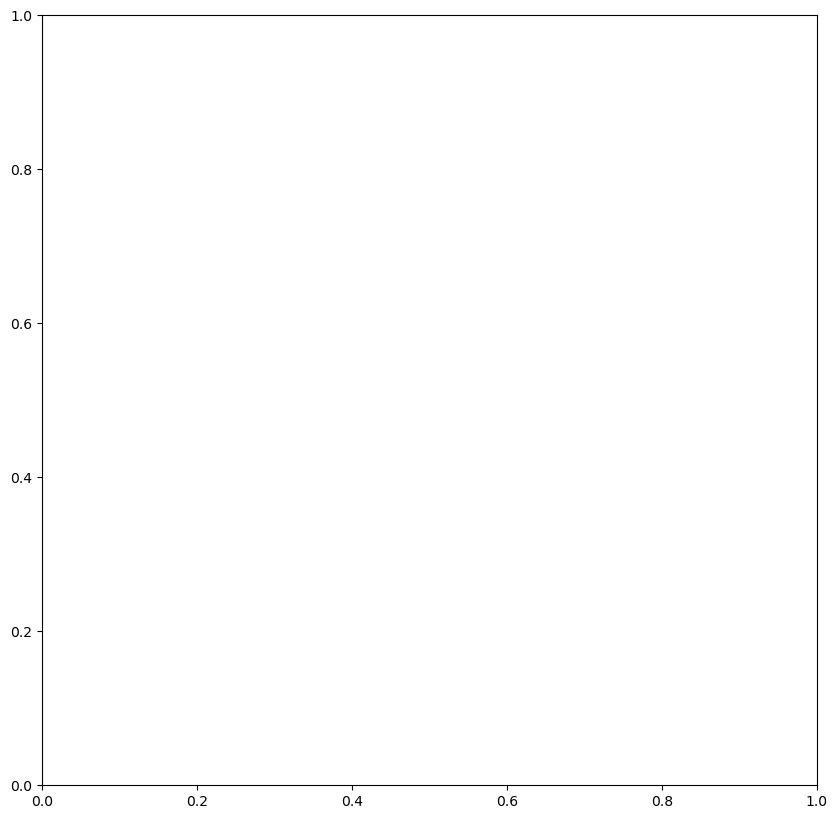

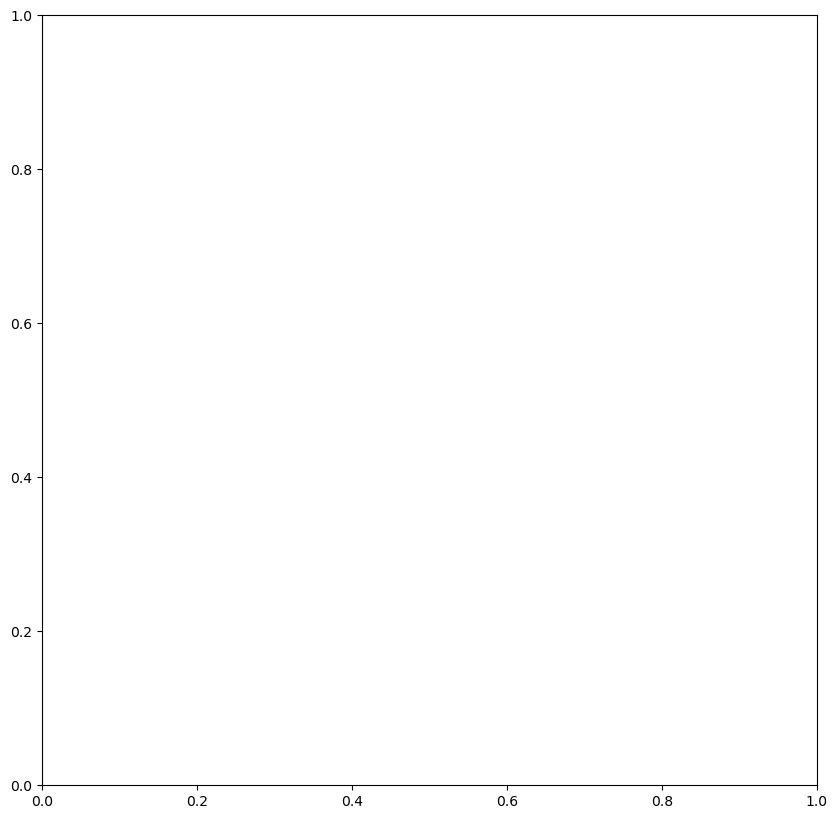

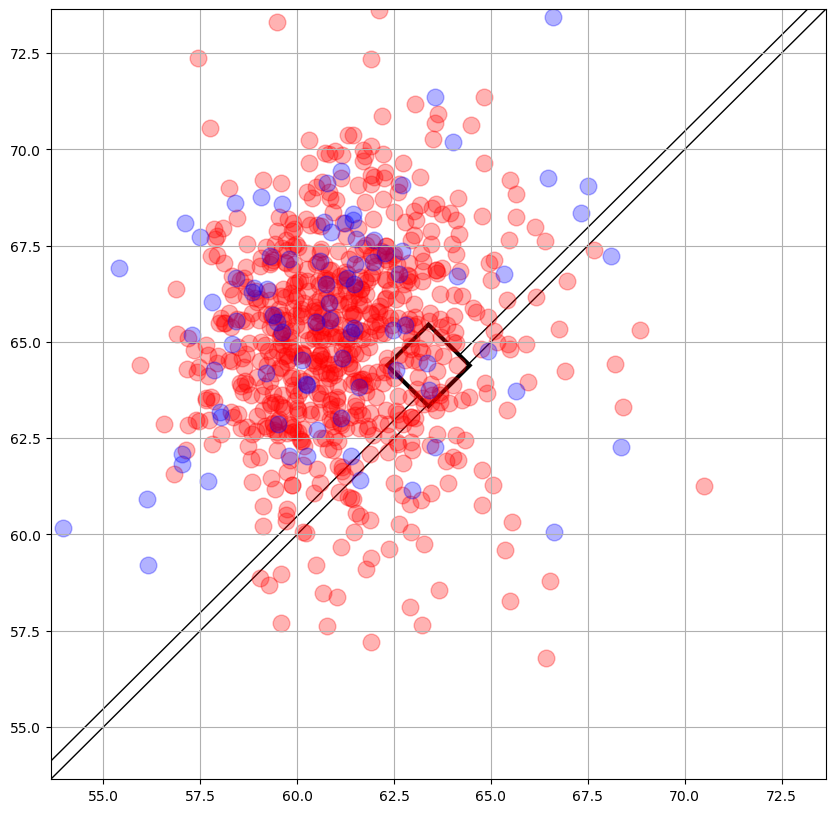

In [93]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

first_base_point = [63.63961031, 63.63961031]

first_baseline = Rectangle(
    (0, 0), 
    300, 
    1/3,
    edgecolor = 'black',
    facecolor="white",
    angle=45,
    rotation_point = (0, 0)
)

ax.add_patch(first_baseline)

first_base = Rectangle(
    [63.63961031 - (1), 63.63961031], 1.5, 1.5,
    edgecolor = 'black',
    facecolor = "white",
    rotation_point="center",
    angle=45,
    fill=True,
    lw=3
)

ax.add_patch(first_base)

ax.scatter(
    trusted_first_base_receives["ball_position_x"], 
    trusted_first_base_receives["ball_position_y"], 
#    trusted_first_base_receives["ball_position_z"], 
    alpha=0.3,
    marker='o',
    s=12 ** 2,
    color="red"
)


ax.scatter(
    trusted_first_base_receives_not_outs["ball_position_x"], 
    trusted_first_base_receives_not_outs["ball_position_y"], 
#    trusted_first_base_receives["ball_position_z"], 
    alpha=0.3,
    marker='o',
    s=12 ** 2,
    color="blue"
)


ax.set_xlim(first_base_point[0] - 10, first_base_point[0] + 10)
ax.set_ylim(first_base_point[1] - 10, first_base_point[1] + 10)

plt.grid()

plt.show()

### Try again with a hexbin and a mean

In [94]:
trusted_first_base_receives["target"] = 1
trusted_first_base_receives_not_outs["target"] = 0

hex_plotting = pd.concat([trusted_first_base_receives, trusted_first_base_receives_not_outs])

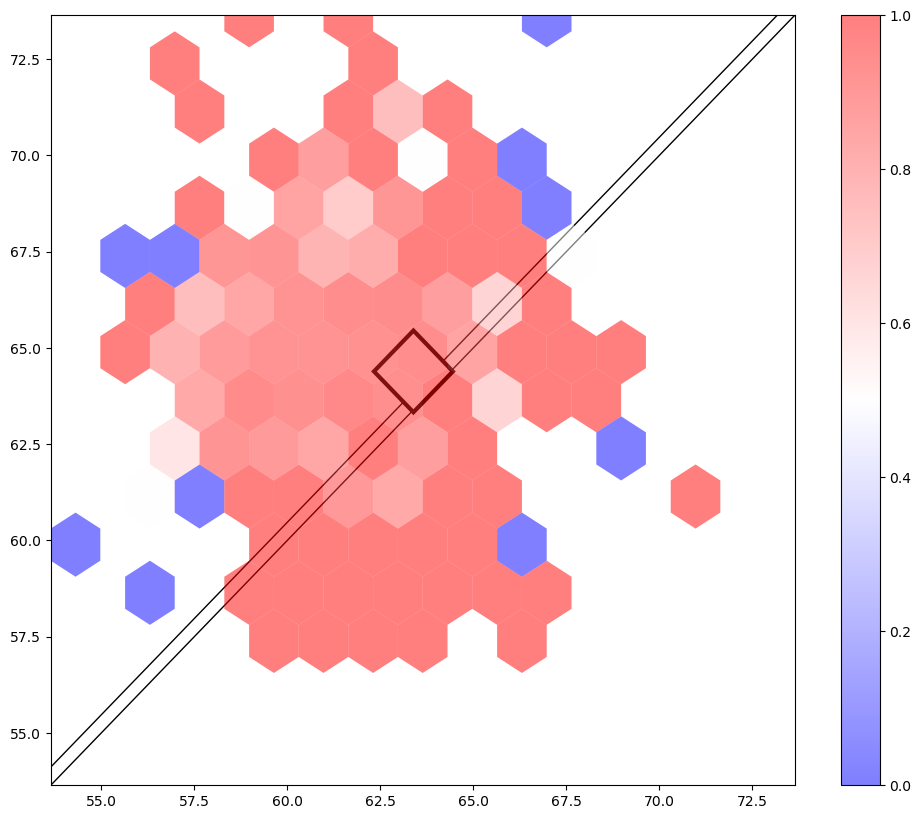

In [95]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot()

first_base_point = [63.63961031, 63.63961031]

first_baseline = Rectangle(
    (0, 0), 
    300, 
    1/3,
    edgecolor = 'black',
    facecolor="white",
    angle=45,
    rotation_point = (0, 0)
)

ax.add_patch(first_baseline)

first_base = Rectangle(
    [63.63961031 - (1), 63.63961031], 1.5, 1.5,
    edgecolor = 'black',
    facecolor = "white",
    rotation_point="center",
    angle=45,
    fill=True,
    lw=3
)

ax.add_patch(first_base)

im = ax.hexbin(hex_plotting["ball_position_x"], 
          hex_plotting["ball_position_y"], 
          C = hex_plotting["target"],
          cmap="bwr", 
          extent = ((first_base_point[0] - 10, first_base_point[0] + 10, first_base_point[1] - 10, first_base_point[1] + 10)),
          edgecolors=None,
          gridsize=15, 
          alpha=0.5) 


ax.set_xlim(first_base_point[0] - 10, first_base_point[0] + 10)
ax.set_ylim(first_base_point[1] - 10, first_base_point[1] + 10)

fig.colorbar(im)

# plt.grid()

plt.show()

### IDK WHY THIS 3D STUFF ISN'T WORKING

In [142]:
from mpl_toolkits import mplot3d
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Polygon, Rectangle

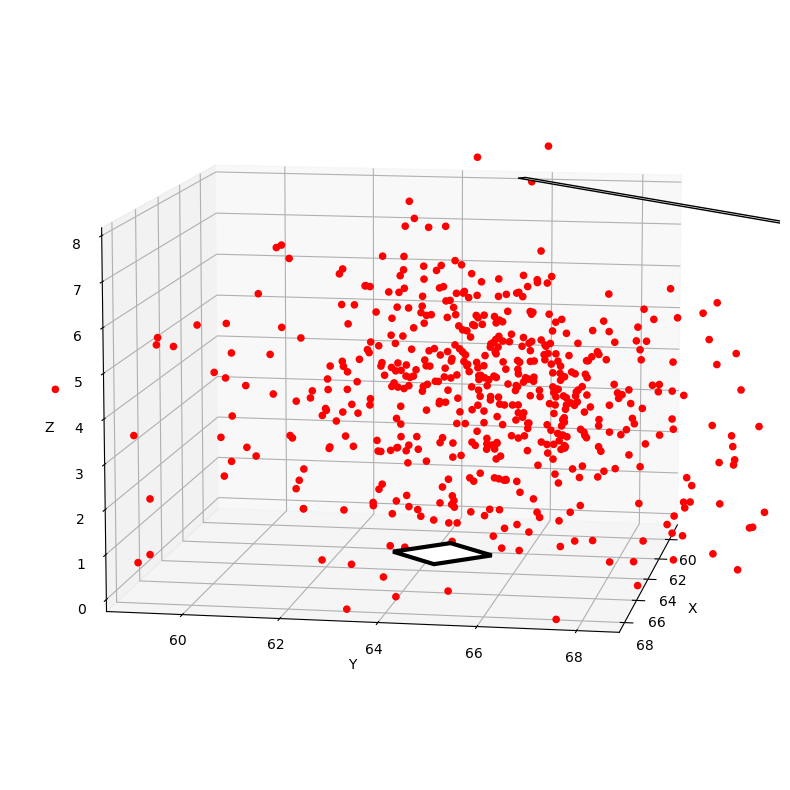

In [237]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(
    trusted_first_base_receives["ball_position_x"], 
    trusted_first_base_receives["ball_position_y"], 
    trusted_first_base_receives["ball_position_z"], 
    alpha=1,
    marker='o',
    color = "red"
)

first_base_point = [63.63961031, 63.63961031]

first_base_line = Rectangle(
    (40, 40), 
    30, 
    1/3,
    edgecolor = 'black',
    facecolor= "white",
    angle=45,
    rotation_point = (0, 0)
)

ax.add_patch(first_base_line)

art3d.pathpatch_2d_to_3d(
    first_base_line, 
    z=0, 
    zdir="z"
)


first_base = Rectangle(
    [63.63961031 - (1), 63.63961031], 1.5, 1.5,
    edgecolor = 'black',
    facecolor = "white",
    rotation_point="center",
    angle=45,
    fill=True,
    lw=3
)

ax.add_patch(first_base)

art3d.pathpatch_2d_to_3d(
    first_base, 
    z=0, 
    zdir="z"
)

ax.set_xlim(first_base_point[0] - 5, first_base_point[0] + 5)
ax.set_ylim(first_base_point[1] - 5, first_base_point[1] + 5)
ax.set_zlim(-0.1, 8)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_aspect("equalxy")

ax.elev = 10 # 3 is roughly Center field camera angle
ax.azim = 10  # xy view 10 is over right shoulder

plt.show()

### Where the balls landed when thrown?
- This would be the same as before, but for all the plays where the ball bounced, use that coord instead and the ball acquired one!
- Maybe "whether the ball bounced"

In [285]:
bf = Baseball_Field("1902_13_TeamMK_TeamB", which_outs=["at_first"])

g_info = bf.game_obj.game_info_df.copy()
g_events = bf.game_obj.game_events_df.copy()


In [291]:
not_outs = g_info.loc[
    g_info["is_out_at_first"] == -1,
]

In [293]:
g_events.head()

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,ball_position_x,ball_position_y,ball_position_z,batter_x,batter_y,player_id
0,1902_13_TeamMK_TeamB,1,1.0,1,30710,1,1,pitch,2.0,ball acquired,31160.0,NaN,NaN,NaN,NaN,NaN,NaN,88.551738,NaN,NaN,-1.836549,51.79020,6.462540,2.5989,-0.5121,1166
1,1902_13_TeamMK_TeamB,1,1.0,1,31160,2,2,ball acquired,5.0,end of play,31160.0,1.0,pitch,30710.0,NaN,NaN,NaN,88.489576,NaN,NaN,-0.042773,-6.19929,1.465419,1.5789,0.5613,2925
2,1902_13_TeamMK_TeamB,1,1.0,1,31160,0,5,end of play,NaN,NaN,NaN,2.0,ball acquired,31160.0,NaN,NaN,NaN,88.489576,NaN,NaN,-0.042773,-6.19929,1.465419,1.5789,0.5613,NaN
3,1902_13_TeamMK_TeamB,2,1.0,2,41610,1,1,pitch,2.0,ball acquired,42060.0,NaN,NaN,NaN,NaN,NaN,NaN,88.577916,NaN,NaN,-1.777089,53.48310,6.388680,2.8674,-0.8025,1166
4,1902_13_TeamMK_TeamB,2,1.0,2,42060,2,2,ball acquired,5.0,end of play,42060.0,1.0,pitch,41610.0,NaN,NaN,NaN,88.508994,NaN,NaN,-1.144251,-4.87377,1.604802,2.9679,-0.8025,2925


In [299]:
g_events.loc[
    (g_events["play_per_game"].isin(not_outs["play_per_game"].values)) &
    (g_events["event"] == "throw (ball-in-play)") &
    (g_events["next_event"] == "ball bounce"),
    :
]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,ball_position_x,ball_position_y,ball_position_z,batter_x,batter_y,player_id
